# Week 7: Dimensionality Reduction & Clustering for Finance Analytics

---

This week, we'll explore powerful techniques for understanding high-dimensional DeFi data:

**What you'll learn:**
- **Principal Component Analysis (PCA)**: Reduce complexity while keeping important information
- **K-Means Clustering**: Group similar tokens for better portfolio decisions
- **Integration**: Combine both techniques for comprehensive market analysis

**Why this matters in DeFi:**
- DeFi tokens have many features (price, volume, TVL, volatility, sentiment, etc.)
- Understanding relationships between these features is crucial
- Grouping similar assets helps with diversification and risk management

**By the end of this notebook, you'll be able to:**
✅ Reduce 20+ features to just 3-5 principal components  
✅ Identify hidden patterns in DeFi markets  
✅ Segment tokens into meaningful clusters  
✅ Build better diversified portfolios  

---

### 🛠️ Setup: Installing Required Libraries

Before we begin, we need to import our tools. Here's what each library does:

- **NumPy**: Mathematical operations and arrays
- **Pandas**: Data manipulation and analysis
- **Matplotlib & Seaborn**: Creating beautiful visualizations
- **Scikit-learn**: Machine learning algorithms (PCA, K-Means, Factor Analysis)

**👉 Run the next cell to import everything we need:**

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

# Set visualization style for better-looking plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Confirm successful import
print("=" * 70)
print("✅ ALL LIBRARIES IMPORTED SUCCESSFULLY!")
print("=" * 70)
print("\n📊 You're ready to begin Week 7: Dimensionality Reduction & Clustering")
print("\nLibraries loaded:")
print("  • NumPy version:", np.__version__)
print("  • Pandas version:", pd.__version__)
print("  • Scikit-learn: Ready for PCA and K-Means")
print("  • Matplotlib & Seaborn: Ready for visualizations")
print("\n" + "=" * 70)

✅ ALL LIBRARIES IMPORTED SUCCESSFULLY!

📊 You're ready to begin Week 7: Dimensionality Reduction & Clustering

Libraries loaded:
  • NumPy version: 2.2.6
  • Pandas version: 2.2.3
  • Scikit-learn: Ready for PCA and K-Means
  • Matplotlib & Seaborn: Ready for visualizations



---

# Part 1: Principal Component Analysis (PCA)

## 🎯 What is PCA and Why Do We Need It?

### The Problem: Too Many Features

Imagine you're analyzing 50 DeFi tokens, each with 20 different features:
- Price returns (daily, weekly, monthly)
- Volatility measures
- Trading volume
- Total Value Locked (TVL)
- Market capitalization
- Liquidity scores
- Correlation with ETH/BTC
- Social sentiment scores
- ... and more!

**That's 1,000 data points to understand!** 😵

### The Solution: PCA

**Principal Component Analysis (PCA)** helps us by:
- Finding the most important patterns in our data
- Reducing 20 features down to 3-5 "principal components"
- Keeping 80-90% of the information while removing noise
- Making data easier to visualize and understand

---

## 🧮 The Intuition Behind PCA

Think of PCA like taking a photograph:

**Imagine you're in a room full of people:**
- You could describe each person individually (many features: height, weight, age, etc.)
- OR you could take a photo from the best angle that captures everyone (one principal component)

**PCA finds the "best angles" (directions) that capture the most variation in your data.**

### Key Concepts:

1. **Principal Component 1 (PC1)**: The direction where data varies the most
   - Example: In DeFi, PC1 might represent "token size" (combining market cap, volume, TVL)

2. **Principal Component 2 (PC2)**: The next direction (perpendicular to PC1) with most remaining variation
   - Example: PC2 might represent "risk" (combining volatility and returns)

3. **Variance Explained**: How much information each component captures
   - We want components that explain 80-90% of total variance

4. **Loadings**: How each original feature contributes to a principal component
   - High loading = feature is important for that component

---

## 📐 The Mathematics (Simplified)

Don't worry if math isn't your strength - here's the simple version:

**Step 1:** Start with your data matrix (tokens × features)
```
         Return  Volatility  Volume  TVL  ...
TOKEN_1   0.05      0.12      1000   5M
TOKEN_2  -0.02      0.08       500   2M
...
```

**Step 2:** Standardize the data (mean=0, std=1)
- This ensures all features are on the same scale
- Without this, large numbers (like market cap in billions) would dominate

**Step 3:** Find directions of maximum variance
- PCA calculates these using eigenvalue decomposition of the covariance matrix
- Don't worry about the details - Python does this for you!

**Step 4:** Transform data to the new principal component space
```
         PC1    PC2    PC3  ...
TOKEN_1  2.3   -0.5    0.1
TOKEN_2  -1.1   1.2    0.3
...
```

---

## 💡 When Should You Use PCA in DeFi?

✅ **USE PCA when you have:**
- Many correlated features (e.g., different volume metrics)
- Need to reduce dimensionality for visualization
- Want to identify underlying market factors
- Need to remove noise from your data
- Want to avoid overfitting in models

❌ **BE CAREFUL when:**
- You have very few features (< 5)
- Features are already uncorrelated
- You need to interpret individual features exactly
- Your data has many outliers

---

## 🏦 Real DeFi Applications of PCA

1. **Risk Management**: Identify main sources of portfolio risk
2. **Market Analysis**: Discover hidden market factors (size, risk, sentiment)
3. **Portfolio Construction**: Select tokens based on different PC exposures
4. **Regime Detection**: Identify when market structure changes
5. **Feature Engineering**: Create better features for ML models

---

**👉 In the next cell, we'll build our PCA class step by step.**

In [2]:
class SimplePCA:
    """
    Principal Component Analysis for DeFi Portfolio Analysis
    
    This class wraps sklearn's PCA with helpful methods for:
    - Fitting PCA to DeFi data
    - Transforming data to PC space
    - Analyzing variance explained
    - Visualizing results
    - Interpreting component loadings
    """
    
    def __init__(self, n_components=None):
        """
        Initialize PCA
        
        Parameters:
        -----------
        n_components : int or None
            Number of components to keep
            - None = keep all components
            - int = keep specific number (e.g., 5)
            - Tip: Start with None to see all, then choose optimal number
        """
        self.n_components = n_components
        self.scaler = StandardScaler()  # For standardizing features
        self.pca = None  # Will hold the fitted PCA model
        self.feature_names = None  # To remember original feature names
        
    def fit(self, X, feature_names=None):
        """
        Fit PCA model to data
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Data matrix (e.g., 50 tokens × 8 features)
        feature_names : list of str, optional
            Names of features for better interpretation
        
        Returns:
        --------
        self : object
            Returns self for method chaining
        """
        # Step 1: Standardize features (VERY IMPORTANT!)
        # This ensures all features have mean=0 and std=1
        X_scaled = self.scaler.fit_transform(X)
        
        # Step 2: Fit PCA
        self.pca = PCA(n_components=self.n_components)
        self.pca.fit(X_scaled)
        
        # Step 3: Save feature names for later use
        self.feature_names = feature_names
        
        # Print summary
        print(f"\n✅ PCA fitted successfully!")
        print(f"   Components: {self.pca.n_components_}")
        print(f"   Total variance explained: {self.pca.explained_variance_ratio_.sum():.2%}")
        
        return self
    
    def transform(self, X):
        """
        Transform data to principal component space
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Data to transform
        
        Returns:
        --------
        X_transformed : array, shape (n_samples, n_components)
            Data in PC space
        """
        X_scaled = self.scaler.transform(X)
        return self.pca.transform(X_scaled)
    
    def fit_transform(self, X, feature_names=None):
        """
        Fit PCA and transform data in one step
        
        This is a convenience method that combines fit() and transform()
        """
        self.fit(X, feature_names)
        return self.transform(X)
    
    def inverse_transform(self, X_pca):
        """
        Reconstruct original features from principal components
        
        Useful for understanding what PCs represent
        """
        X_scaled = self.pca.inverse_transform(X_pca)
        return self.scaler.inverse_transform(X_scaled)
    
    def get_variance_summary(self):
        """
        Get detailed variance statistics for each component
        
        Returns:
        --------
        DataFrame with columns:
        - PC: Component name (PC1, PC2, ...)
        - Variance_Explained: Proportion of variance (0 to 1)
        - Cumulative_Variance: Running total of variance
        - Eigenvalue: The actual eigenvalue (variance in that direction)
        """
        var_exp = self.pca.explained_variance_ratio_
        cum_var = np.cumsum(var_exp)
        
        df = pd.DataFrame({
            'PC': [f'PC{i+1}' for i in range(len(var_exp))],
            'Variance_Explained': var_exp,
            'Cumulative_Variance': cum_var,
            'Eigenvalue': self.pca.explained_variance_
        })
        
        return df
    
    def get_loadings(self):
        """
        Get feature loadings (how features relate to PCs)
        
        Loadings tell us:
        - Which features contribute most to each PC
        - Direction of relationship (positive or negative)
        
        Returns:
        --------
        DataFrame with features as rows, PCs as columns
        
        Interpretation:
        - High positive loading: Feature increases with PC
        - High negative loading: Feature decreases with PC  
        - Near-zero loading: Feature unrelated to PC
        """
        loadings = pd.DataFrame(
            self.pca.components_.T,
            columns=[f'PC{i+1}' for i in range(self.pca.n_components_)],
            index=self.feature_names if self.feature_names else range(self.pca.n_components_)
        )
        return loadings
    
    def plot_scree(self, figsize=(14, 5)):
        """
        Create scree plot to help choose optimal number of components
        
        The scree plot shows:
        - Left: Variance per component (look for "elbow")
        - Right: Cumulative variance (aim for 80-90%)
        """
        var_summary = self.get_variance_summary()
        
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
        # Left plot: Scree Plot
        axes[0].bar(var_summary['PC'], var_summary['Variance_Explained'], 
                    alpha=0.7, color='steelblue')
        axes[0].plot(var_summary['PC'], var_summary['Variance_Explained'], 
                     'ro-', linewidth=2, markersize=8)
        axes[0].set_xlabel('Principal Component', fontsize=12)
        axes[0].set_ylabel('Variance Explained', fontsize=12)
        axes[0].set_title('Scree Plot\n(Look for the "elbow")', 
                         fontsize=13, fontweight='bold')
        axes[0].grid(True, alpha=0.3)
        axes[0].tick_params(axis='x', rotation=45)
        
        # Right plot: Cumulative Variance
        axes[1].plot(var_summary['PC'], var_summary['Cumulative_Variance'], 
                     'bo-', linewidth=2, markersize=8)
        axes[1].axhline(y=0.80, color='green', linestyle='--', 
                        linewidth=2, label='80% threshold')
        axes[1].axhline(y=0.90, color='orange', linestyle='--', 
                        linewidth=2, label='90% threshold')
        axes[1].set_xlabel('Number of Components', fontsize=12)
        axes[1].set_ylabel('Cumulative Variance Explained', fontsize=12)
        axes[1].set_title('Cumulative Variance Explained', 
                         fontsize=13, fontweight='bold')
        axes[1].legend(fontsize=10)
        axes[1].grid(True, alpha=0.3)
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].set_ylim([0, 1.05])
        
        plt.tight_layout()
        return fig
    
    def plot_loadings(self, n_components=3, n_top_features=10, figsize=(15, 5)):
        """
        Visualize feature loadings for top components
        
        Shows which features are most important for each PC
        
        Parameters:
        -----------
        n_components : int
            Number of PCs to display (default: 3)
        n_top_features : int
            How many features to show per PC (default: 10)
        """
        loadings = self.get_loadings()
        n_components = min(n_components, loadings.shape[1])
        
        fig, axes = plt.subplots(1, n_components, figsize=figsize)
        if n_components == 1:
            axes = [axes]
        
        for i in range(n_components):
            pc_col = f'PC{i+1}'
            
            # Get top features by absolute loading
            top_features = loadings[pc_col].abs().nlargest(n_top_features)
            sorted_loadings = loadings.loc[top_features.index, pc_col].sort_values()
            
            # Color code: red=negative, green=positive
            colors = ['red' if x < 0 else 'green' for x in sorted_loadings.values]
            
            axes[i].barh(range(len(sorted_loadings)), sorted_loadings.values, 
                        color=colors, alpha=0.7)
            axes[i].set_yticks(range(len(sorted_loadings)))
            axes[i].set_yticklabels(sorted_loadings.index, fontsize=9)
            axes[i].set_xlabel('Loading', fontsize=11)
            axes[i].set_title(f'{pc_col}\n({self.pca.explained_variance_ratio_[i]:.1%} variance)', 
                            fontsize=12, fontweight='bold')
            axes[i].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
            axes[i].grid(True, alpha=0.3, axis='x')
        
        plt.tight_layout()
        return fig

print("=" * 70)
print("✅ SimplePCA class created successfully!")
print("=" * 70)
print("\nAvailable methods:")
print("  • fit(X, feature_names) - Fit PCA to data")
print("  • transform(X) - Transform data to PC space")
print("  • fit_transform(X, feature_names) - Fit and transform in one step")
print("  • get_variance_summary() - Get variance statistics")
print("  • get_loadings() - Get feature loadings")
print("  • plot_scree() - Visualize variance explained")
print("  • plot_loadings() - Visualize feature importance")
print("\n👉 Next: We'll generate some synthetic DeFi data to practice with")
print("=" * 70)

✅ SimplePCA class created successfully!

Available methods:
  • fit(X, feature_names) - Fit PCA to data
  • transform(X) - Transform data to PC space
  • fit_transform(X, feature_names) - Fit and transform in one step
  • get_variance_summary() - Get variance statistics
  • get_loadings() - Get feature loadings
  • plot_scree() - Visualize variance explained
  • plot_loadings() - Visualize feature importance

👉 Next: We'll generate some synthetic DeFi data to practice with


---

## 📊 Generating Synthetic DeFi Portfolio Data

### Why Start with Synthetic Data?

Before working with real DeFi data (which can be messy and incomplete), we'll create **realistic synthetic data** to:

✅ **Learn the techniques** without API complications  
✅ **Understand patterns** we deliberately create  
✅ **Control the experiment** - we know the "ground truth"  
✅ **Practice interpretation** in a safe environment  

Later, you can apply these exact same techniques to real data from CoinGecko, CoinMarketCap, or on-chain sources!

---

### 🎲 What Data Will We Generate?

We'll create a portfolio of **50 DeFi tokens**, each with **8 realistic features**:

| Feature | Description | Range | Why It Matters |
|---------|-------------|-------|----------------|
| **Mean_Return** | Average daily return | -5% to +5% | Profitability measure |
| **Volatility** | Price volatility (30-day) | 2% to 10% | Risk measure |
| **Volume_USD** | Daily trading volume | $100K to $100M | Liquidity indicator |
| **TVL_USD** | Total Value Locked | $1M to $1B | Protocol size |
| **Market_Cap** | Token market cap | $10M to $10B | Token size |
| **Liquidity_Score** | Ease of trading | 0 to 100 | Trading friction |
| **ETH_Correlation** | Correlation with Ethereum | -1 to +1 | Market exposure |
| **Sentiment_Score** | Social sentiment | 0 to 100 | Market perception |

---

### 🎯 Creating Realistic Token Groups

To make this realistic, we'll create **3 distinct groups** of tokens:

#### 1. **High-Cap Stable Tokens** (30% of portfolio)
- Large, established protocols (like Uniswap, Aave)
- **Characteristics:**
  - Lower volatility (more stable)
  - Higher liquidity (easy to trade)
  - Large market cap
  - Lower but steady returns

#### 2. **Mid-Cap Growth Tokens** (40% of portfolio)
- Medium-sized protocols with growth potential
- **Characteristics:**
  - Moderate volatility
  - Moderate liquidity
  - Higher returns (but riskier)
  - Good balance of risk/reward

#### 3. **Low-Cap High-Risk Tokens** (30% of portfolio)
- Smaller, newer protocols (higher risk/reward)
- **Characteristics:**
  - High volatility (price swings)
  - Lower liquidity (harder to trade)
  - Potential for high returns
  - Higher risk of loss

---

### 🔬 The Statistical Process

We'll use different **probability distributions** to model each feature:

- **Normal distribution** → Returns, Sentiment (symmetric around mean)
- **Gamma distribution** → Volatility (always positive, skewed right)
- **Log-normal distribution** → Volume, TVL, Market Cap (highly skewed, realistic for financial data)
- **Beta distribution** → Liquidity, Correlation (bounded between values)

**Don't worry about the math** - the key point is: different features have different natural patterns, and we're simulating them realistically!

---

### 💡 Why This Matters for PCA

By creating **structured groups**, we're simulating what PCA should discover:

- **PC1** might capture "token size" (combining Volume, TVL, Market Cap)
- **PC2** might capture "risk profile" (combining Volatility, Returns)
- **PC3** might capture "market exposure" (ETH correlation, sentiment)

**The exciting part:** PCA should find these patterns automatically, without us telling it!

---

### 🎓 Learning Objective

After generating this data, you'll be able to:
1. See what realistic DeFi portfolio data looks like
2. Understand correlations between features
3. Have clean data to practice PCA on
4. Later compare with your own real DeFi data

---

**👉 Run the next cell to generate our synthetic DeFi portfolio!**

In [3]:
def generate_defi_portfolio_data(n_tokens=50, random_state=42):
    """
    Generate synthetic DeFi portfolio data with realistic features
    
    This function creates a dataset that mimics real DeFi token characteristics,
    including natural correlations and three distinct token groups.
    
    Parameters:
    -----------
    n_tokens : int, default=50
        Number of tokens to generate
    random_state : int, default=42
        Random seed for reproducibility (same seed = same data)
    
    Returns:
    --------
    df : DataFrame
        Portfolio data with tokens as rows, features as columns
    """
    # Set random seed for reproducibility
    np.random.seed(random_state)
    
    # Generate token names
    token_names = [f'TOKEN_{i+1}' for i in range(n_tokens)]
    
    print("🎲 Generating synthetic DeFi portfolio data...")
    print(f"   Creating {n_tokens} tokens with 8 features each\n")
    
    # Generate base features using realistic distributions
    data = {
        # Returns: Normal distribution (can be positive or negative)
        # Mean slightly positive (0.1% daily), with variation
        'Mean_Return': np.random.normal(0.001, 0.05, n_tokens),
        
        # Volatility: Gamma distribution (always positive, right-skewed)
        # Typical crypto volatility: 2-8% daily
        'Volatility': np.random.gamma(2, 0.02, n_tokens),
        
        # Volume: Log-normal (highly skewed, like real trading volume)
        # Range: roughly $100K to $100M
        'Volume_USD': np.random.lognormal(15, 2, n_tokens),
        
        # TVL: Log-normal (realistic for protocol sizes)
        # Range: roughly $1M to $1B
        'TVL_USD': np.random.lognormal(17, 2, n_tokens),
        
        # Market Cap: Log-normal (realistic for token valuations)
        # Range: roughly $10M to $10B
        'Market_Cap': np.random.lognormal(18, 2.5, n_tokens),
        
        # Liquidity Score: Beta distribution (bounded 0-100)
        # Most tokens have decent liquidity
        'Liquidity_Score': np.random.beta(5, 2, n_tokens) * 100,
        
        # ETH Correlation: Beta distribution scaled to [-1, 1]
        # Most tokens positively correlated with ETH
        'ETH_Correlation': np.random.beta(5, 2, n_tokens) * 2 - 1,
        
        # Sentiment: Normal distribution around 50
        # Range: 0-100, centered at 50 (neutral)
        'Sentiment_Score': np.random.normal(50, 15, n_tokens)
    }
    
    # Create DataFrame
    df = pd.DataFrame(data, index=token_names)
    
    # Now add structure: create 3 distinct token groups
    print("📊 Creating token groups with distinct characteristics...")
    
    # Calculate group sizes
    n_group1 = int(n_tokens * 0.3)  # 30% - High-cap stable
    n_group2 = int(n_tokens * 0.4)  # 40% - Mid-cap growth
    # Remaining 30% - Low-cap high-risk
    
    # GROUP 1: High-cap stable tokens (like Uniswap, Aave)
    # Lower volatility, higher liquidity
    print(f"   Group 1 (High-cap stable): {n_group1} tokens")
    df.iloc[:n_group1, df.columns.get_loc('Volatility')] *= 0.5  # 50% less volatile
    df.iloc[:n_group1, df.columns.get_loc('Liquidity_Score')] *= 1.3  # 30% more liquid
    df.iloc[:n_group1, df.columns.get_loc('Market_Cap')] *= 1.5  # Larger market cap
    
    # GROUP 2: Mid-cap growth tokens
    # Higher returns, moderate risk
    print(f"   Group 2 (Mid-cap growth): {n_group2} tokens")
    df.iloc[n_group1:n_group1+n_group2, df.columns.get_loc('Mean_Return')] *= 1.5  # 50% higher returns
    df.iloc[n_group1:n_group1+n_group2, df.columns.get_loc('Volatility')] *= 1.2  # 20% more volatile
    
    # GROUP 3: Low-cap high-risk tokens (remaining tokens)
    # High volatility, lower liquidity, high potential returns
    print(f"   Group 3 (Low-cap high-risk): {n_tokens - n_group1 - n_group2} tokens")
    df.iloc[n_group1+n_group2:, df.columns.get_loc('Volatility')] *= 2.0  # 2x more volatile
    df.iloc[n_group1+n_group2:, df.columns.get_loc('Mean_Return')] *= 2.0  # 2x returns (high risk/reward)
    df.iloc[n_group1+n_group2:, df.columns.get_loc('Liquidity_Score')] *= 0.6  # 40% less liquid
    df.iloc[n_group1+n_group2:, df.columns.get_loc('Market_Cap')] *= 0.3  # Smaller market cap
    
    # Clip values to reasonable ranges
    df['Liquidity_Score'] = df['Liquidity_Score'].clip(0, 100)
    df['Sentiment_Score'] = df['Sentiment_Score'].clip(0, 100)
    df['ETH_Correlation'] = df['ETH_Correlation'].clip(-1, 1)
    
    return df


# Generate the data
print("=" * 70)
defi_data = generate_defi_portfolio_data(n_tokens=50, random_state=42)
print("\n✅ Data generation complete!")
print("=" * 70)

# Display basic information
print(f"\n📋 Dataset Overview:")
print(f"   Shape: {defi_data.shape[0]} tokens × {defi_data.shape[1]} features")
print(f"   Memory usage: {defi_data.memory_usage(deep=True).sum() / 1024:.2f} KB")

print("\n📊 First 5 tokens:")
display(defi_data.head())

print("\n📈 Statistical Summary:")
display(defi_data.describe().round(3))

print("\n🔍 Feature Correlations (top 3):")
corr_matrix = defi_data.corr()
# Get the upper triangle of correlation matrix (avoid duplicates)
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_pairs.append({
            'Feature 1': corr_matrix.columns[i],
            'Feature 2': corr_matrix.columns[j],
            'Correlation': corr_matrix.iloc[i, j]
        })
corr_df = pd.DataFrame(corr_pairs)
corr_df = corr_df.reindex(corr_df['Correlation'].abs().sort_values(ascending=False).index)
print("\nStrongest correlations:")
display(corr_df.head(3))

print("\n💡 What to notice:")
print("   • Market_Cap, TVL, and Volume are likely correlated (size factors)")
print("   • Mean_Return and Volatility might be related (risk-return tradeoff)")
print("   • Three distinct groups exist (but PCA will discover them!)")
print("\n" + "=" * 70)

🎲 Generating synthetic DeFi portfolio data...
   Creating 50 tokens with 8 features each

📊 Creating token groups with distinct characteristics...
   Group 1 (High-cap stable): 15 tokens
   Group 2 (Mid-cap growth): 20 tokens
   Group 3 (Low-cap high-risk): 15 tokens

✅ Data generation complete!

📋 Dataset Overview:
   Shape: 50 tokens × 8 features
   Memory usage: 5.90 KB

📊 First 5 tokens:


,Mean_Return,Volatility,Volume_USD,TVL_USD,Market_Cap,Liquidity_Score,ETH_Correlation,Sentiment_Score
TOKEN_1,0.025836,0.021210,5.197751e+05,1.544930e+07,2.094834e+10,100.000000,0.715521,25.177150
TOKEN_2,-0.005913,0.012173,7.255597e+07,1.007347e+08,4.804639e+08,100.000000,0.256876,46.551806
TOKEN_3,0.033384,0.009366,6.824834e+05,6.223793e+07,6.231912e+05,69.820302,0.520265,59.422100
TOKEN_4,0.077151,0.025876,1.716636e+06,2.088083e+07,1.569756e+08,99.688262,0.556776,69.051883
TOKEN_5,-0.010708,0.033834,1.663525e+07,4.441100e+06,1.883070e+07,97.233297,-0.325745,37.722887



📈 Statistical Summary:


,Mean_Return,Volatility,Volume_USD,TVL_USD,Market_Cap,Liquidity_Score,ETH_Correlation,Sentiment_Score
count,50.000,50.000,5.000000e+01,5.000000e+01,5.000000e+01,50.000,50.000,50.000
mean,-0.019,0.049,2.967125e+07,1.173176e+09,1.111613e+09,67.862,0.468,45.956
std,0.072,0.049,1.086343e+08,7.578585e+09,3.615874e+09,25.134,0.273,14.382
min,-0.194,0.008,1.312729e+05,5.769262e+05,1.986732e+04,20.768,-0.326,10.110
25%,-0.069,0.020,6.928591e+05,5.973228e+06,6.731811e+06,48.973,0.274,37.796
50%,-0.013,0.034,5.446151e+06,3.065108e+07,3.122104e+07,68.128,0.486,47.697
75%,0.026,0.056,1.474843e+07,8.557438e+07,4.317245e+08,93.033,0.697,52.885
max,0.140,0.292,7.535744e+08,5.363475e+10,2.094834e+10,100.000,0.949,88.549



🔍 Feature Correlations (top 3):

Strongest correlations:


,Feature 1,Feature 2,Correlation
10,Volatility,Liquidity_Score,-0.381788
24,Market_Cap,Sentiment_Score,-0.259894
4,Mean_Return,Liquidity_Score,0.257752



💡 What to notice:
   • Market_Cap, TVL, and Volume are likely correlated (size factors)
   • Mean_Return and Volatility might be related (risk-return tradeoff)
   • Three distinct groups exist (but PCA will discover them!)



---

## 🎯 Applying PCA to Our DeFi Data

### What We're About to Do

Now that we have our synthetic DeFi portfolio data, let's use PCA to:
1. **Reduce** 8 features down to a smaller number of principal components
2. **Discover** which features naturally group together
3. **Understand** the main sources of variation in our portfolio
4. **Visualize** complex relationships in 2D space

---

### 🤔 Key Questions We'll Answer

Before running PCA, think about these questions:

**Q1: How many principal components do we need?**
- We have 8 features, so we can have up to 8 PCs
- But we probably don't need all 8!
- Goal: Keep enough PCs to explain 80-90% of variance

**Q2: What will the principal components represent?**
- PC1: Likely a "size factor" (Market Cap + TVL + Volume)
- PC2: Possibly a "risk factor" (Volatility + Returns)
- PC3: Maybe "market dynamics" (ETH Correlation + Sentiment)

**Q3: Which features are most important?**
- Loadings will tell us which features contribute most to each PC
- High loadings = important features
- Low loadings = less important features

---

### 📋 Step-by-Step Process

Here's what happens when we call `fit_transform()`:
```
Step 1: Standardization
├─ Original data: different scales (Market Cap in billions, Returns in decimals)
├─ Standardized data: all features have mean=0, std=1
└─ Why? So large numbers don't dominate the analysis

Step 2: Calculate Covariance Matrix
├─ Measures how features vary together
├─ High covariance = features move together
└─ This matrix is 8×8 (one entry for each feature pair)

Step 3: Eigendecomposition
├─ Find eigenvectors (directions of maximum variance)
├─ Find eigenvalues (amount of variance in each direction)
└─ Sort by eigenvalues (largest first = PC1, PC2, ...)

Step 4: Transform Data
├─ Project original data onto principal components
├─ Input: 50 tokens × 8 features
└─ Output: 50 tokens × k components (we'll use k=5)
```

---

### 🎓 What to Look For

After running PCA, we'll examine:

**1. Variance Explained**
```
PC1: 35% of variance  ← Most important
PC2: 25% of variance  ← Second most important
PC3: 15% of variance
PC4: 10% of variance
PC5: 8% of variance
───────────────────
Total: 93% of variance ← Good! We kept most information
```

**2. Loadings (Feature Importance)**
```
PC1 Loadings:
  Market_Cap:  0.85  ← High positive loading
  TVL_USD:     0.82  ← High positive loading
  Volume_USD:  0.78  ← High positive loading
  
Interpretation: PC1 represents "TOKEN SIZE"
```

**3. Scree Plot**
- Shows variance per component
- Look for "elbow" where variance drops sharply
- Components after elbow add little value

---

### 💡 Success Criteria

Our PCA is successful if:

✅ **First 3-5 PCs explain 80-90% of variance**
- Means we successfully reduced dimensionality

✅ **PC loadings are interpretable**
- We can give meaningful names to PCs

✅ **Scree plot shows clear elbow**
- Easy to decide how many PCs to keep

✅ **Features group logically**
- Size features load on same PC
- Risk features load on same PC

---

### ⚠️ Important Reminders

**Remember:**
- PCA assumes **linear relationships** between features
- **Outliers** can affect results (our synthetic data is clean)
- **Standardization is critical** (SimplePCA does this automatically)
- PCs are **orthogonal** (perpendicular) - no correlation between them

---

**👉 Run the next cell to fit PCA to our DeFi portfolio!**

We'll use **n_components=5** to start (keeping 5 out of 8 dimensions).

In [4]:
print("=" * 70)
print("FITTING PCA TO DeFi PORTFOLIO DATA")
print("=" * 70)

# Initialize PCA with 5 components
# Why 5? It's a good starting point - not too few, not too many
# We'll use the scree plot to decide if we should adjust
print("\n🔧 Initializing PCA model...")
print("   Setting n_components=5 (keeping 5 out of 8 dimensions)")

pca_model = SimplePCA(n_components=5)

# Fit PCA and transform data in one step
print("\n⚙️  Fitting PCA and transforming data...")
print("   This will:")
print("   1. Standardize all features (mean=0, std=1)")
print("   2. Calculate principal components")
print("   3. Transform data to PC space")

X_pca = pca_model.fit_transform(
    defi_data.values,  # The actual data (as numpy array)
    feature_names=defi_data.columns.tolist()  # Feature names for interpretation
)

print("\n" + "=" * 70)
print("TRANSFORMATION COMPLETE!")
print("=" * 70)

# Show dimensionality reduction
print(f"\n📊 Dimensionality Reduction:")
print(f"   Original shape: {defi_data.shape[0]} tokens × {defi_data.shape[1]} features")
print(f"   Reduced shape:  {X_pca.shape[0]} tokens × {X_pca.shape[1]} components")
print(f"   Reduction: {defi_data.shape[1]} → {X_pca.shape[1]} dimensions")
print(f"   Space savings: {(1 - X_pca.shape[1]/defi_data.shape[1])*100:.1f}% fewer dimensions!")

# Get variance summary
variance_summary = pca_model.get_variance_summary()

print(f"\n📈 Variance Explained by Each Component:")
print("=" * 70)
display(variance_summary.round(4))

# Highlight key findings
total_var = variance_summary['Cumulative_Variance'].iloc[-1]
pc1_var = variance_summary['Variance_Explained'].iloc[0]
pc2_var = variance_summary['Variance_Explained'].iloc[1]
pc3_var = variance_summary['Variance_Explained'].iloc[2]

print("\n🔍 Key Insights:")
print(f"   • PC1 alone captures {pc1_var:.1%} of all variation")
print(f"   • PC1 + PC2 together capture {variance_summary['Cumulative_Variance'].iloc[1]:.1%}")
print(f"   • First 3 PCs capture {variance_summary['Cumulative_Variance'].iloc[2]:.1%}")
print(f"   • All 5 PCs capture {total_var:.1%} of total variance")

# Interpretation
if total_var >= 0.90:
    print(f"\n✅ Excellent! {total_var:.1%} variance retained with just 5 components!")
elif total_var >= 0.80:
    print(f"\n✅ Good! {total_var:.1%} variance retained - acceptable for most applications")
else:
    print(f"\n⚠️  Only {total_var:.1%} variance retained - might need more components")

# Show a preview of transformed data
print(f"\n📋 Sample of Transformed Data (PC space):")
print("   First 5 tokens in principal component coordinates:")
X_pca_df = pd.DataFrame(
    X_pca[:5],  # First 5 tokens
    columns=[f'PC{i+1}' for i in range(X_pca.shape[1])],
    index=defi_data.index[:5]
)
display(X_pca_df.round(3))

print("\n💡 Understanding the transformed data:")
print("   • Each row is still a token")
print("   • Each column is now a principal component (not original features)")
print("   • Values represent the token's 'score' on that component")
print("   • Positive values = high on that component")
print("   • Negative values = low on that component")

print("\n" + "=" * 70)
print("✅ PCA fitting complete! Data successfully transformed.")
print("=" * 70)

print("\n👉 Next: We'll visualize the variance explained with a scree plot")

FITTING PCA TO DeFi PORTFOLIO DATA

🔧 Initializing PCA model...
   Setting n_components=5 (keeping 5 out of 8 dimensions)

⚙️  Fitting PCA and transforming data...
   This will:
   1. Standardize all features (mean=0, std=1)
   2. Calculate principal components
   3. Transform data to PC space

✅ PCA fitted successfully!
   Components: 5
   Total variance explained: 77.20%

TRANSFORMATION COMPLETE!

📊 Dimensionality Reduction:
   Original shape: 50 tokens × 8 features
   Reduced shape:  50 tokens × 5 components
   Reduction: 8 → 5 dimensions
   Space savings: 37.5% fewer dimensions!

📈 Variance Explained by Each Component:


,PC,Variance_Explained,Cumulative_Variance,Eigenvalue
0,PC1,0.2238,0.2238,1.8273
1,PC2,0.1655,0.3894,1.3512
2,PC3,0.1434,0.5327,1.1704
3,PC4,0.1264,0.6591,1.0317
4,PC5,0.1128,0.7720,0.9211



🔍 Key Insights:
   • PC1 alone captures 22.4% of all variation
   • PC1 + PC2 together capture 38.9%
   • First 3 PCs capture 53.3%
   • All 5 PCs capture 77.2% of total variance

⚠️  Only 77.2% variance retained - might need more components

📋 Sample of Transformed Data (PC space):
   First 5 tokens in principal component coordinates:


,PC1,PC2,PC3,PC4,PC5
TOKEN_1,4.081,-1.987,0.437,2.223,-0.286
TOKEN_2,0.652,0.930,0.862,-0.440,-0.357
TOKEN_3,0.391,0.722,-0.100,-1.022,-0.003
TOKEN_4,0.895,1.653,-0.421,-1.365,-0.143
TOKEN_5,-0.062,1.637,1.309,0.368,0.579



💡 Understanding the transformed data:
   • Each row is still a token
   • Each column is now a principal component (not original features)
   • Values represent the token's 'score' on that component
   • Positive values = high on that component
   • Negative values = low on that component

✅ PCA fitting complete! Data successfully transformed.

👉 Next: We'll visualize the variance explained with a scree plot


---

## 📊 Understanding the Scree Plot

### What is a Scree Plot?

A **scree plot** is your main tool for deciding how many principal components to keep.

The name comes from geology: "scree" is the pile of rocks at the bottom of a cliff. The plot looks like a cliff face - it starts steep (important components) and flattens out (less important components).

---

### 📈 Two Plots, One Decision

We'll create **two complementary visualizations**:

#### Plot 1: Scree Plot (Variance per Component)
```
Variance
   |  ●
   |     ●
   |        ●
   |           ●___●___●___●  ← "Scree" (less important)
   |  ^
   |  |
   |  └─ "Elbow" (cutoff point)
   |
   └──────────────────────────
      PC1  PC2  PC3  PC4  PC5
```

**What to look for:**
- **Steep drop** at the beginning = important components
- **Elbow point** = where the curve flattens
- **Flat part** (the "scree") = components that add little value

**Rule of thumb:** Keep components up to (and including) the elbow.

---

#### Plot 2: Cumulative Variance
```
Cumulative
Variance
   100% |                    ●___
    90% |               ●        ← Goal: reach here
    80% |          ●            ← Minimum acceptable
        |      ●
        |  ●
     0% |
        └──────────────────────────
           PC1  PC2  PC3  PC4  PC5
```

**What to look for:**
- **80% line (green)** = minimum threshold for most applications
- **90% line (orange)** = ideal threshold
- **Where curve hits threshold** = how many PCs you need

**Rule of thumb:** 
- Keep enough PCs to explain **80-90%** of variance
- More than 90% = excellent
- Less than 80% = might be losing too much information

---

### 🎯 How to Decide: The Decision Matrix

| Variance Retained | Number of PCs | Decision |
|------------------|---------------|----------|
| < 70% | Too few | ⚠️ Add more components |
| 70-80% | Acceptable | ✅ OK for exploratory analysis |
| 80-90% | Good | ✅ Ideal for most applications |
| 90-95% | Excellent | ✅ Great balance |
| > 95% | Possibly too many | ⚠️ May be keeping noise |

---

### 🔍 Real-World Example Interpretations

**Scenario 1: Clear Elbow**
```
Scree Plot: 40% → 25% → 15% → 8% → 5% → 3% → 2%
                          ↑
                       Elbow here!
Decision: Keep 3 components (80% variance)
```

**Scenario 2: Gradual Decline**
```
Scree Plot: 30% → 20% → 15% → 12% → 10% → 8% → 5%
                          No obvious elbow
Decision: Use cumulative variance plot, aim for 80-90%
```

**Scenario 3: Dominant First Component**
```
Scree Plot: 70% → 10% → 8% → 5% → 4% → 2% → 1%
            ↑
         PC1 dominates!
Decision: PC1 captures most variation - other PCs less important
```

---

### 💡 Why This Matters in DeFi

**Keeping too few components:**
❌ Lose important information about token diversity  
❌ Miss subtle risk patterns  
❌ Oversimplify market structure  

**Keeping too many components:**
❌ Include noise instead of signal  
❌ Make models overly complex  
❌ Harder to interpret results  

**Getting it just right:**
✅ Balance between simplicity and completeness  
✅ Retain meaningful patterns  
✅ Remove noise and redundancy  

---

### 🎓 What You'll Learn from Our Plot

After running the next cell, you should be able to answer:

1. **Where is the elbow?** (Which PC does the curve flatten at?)
2. **How many PCs for 80% variance?** (Read from cumulative plot)
3. **How many PCs for 90% variance?** (Read from cumulative plot)
4. **Is PC1 dominant?** (Does it explain > 40% alone?)
5. **What's our recommendation?** (Based on both plots)

---

### 📝 Interpretation Tips

**Strong first component (PC1 > 40%):**
- Suggests one dominant factor drives variation
- In DeFi: Often "size" (Market Cap, TVL, Volume)
- Interpretation: Market dominated by large vs. small tokens

**Balanced components (PC1 ≈ PC2 ≈ PC3):**
- Multiple independent factors at play
- In DeFi: Size, risk, sentiment all matter equally
- Interpretation: Complex market with multiple dynamics

**Gradual decline (no clear elbow):**
- Variation spread across many factors
- In DeFi: Many small, independent patterns
- Interpretation: Diverse portfolio with many micro-factors

---

**👉 Run the next cell to create the scree plot and determine optimal components!**

VISUALIZING VARIANCE EXPLAINED - SCREE PLOT

📊 Creating scree plot to determine optimal number of components...
   This will help us decide: 'How many PCs should we keep?'



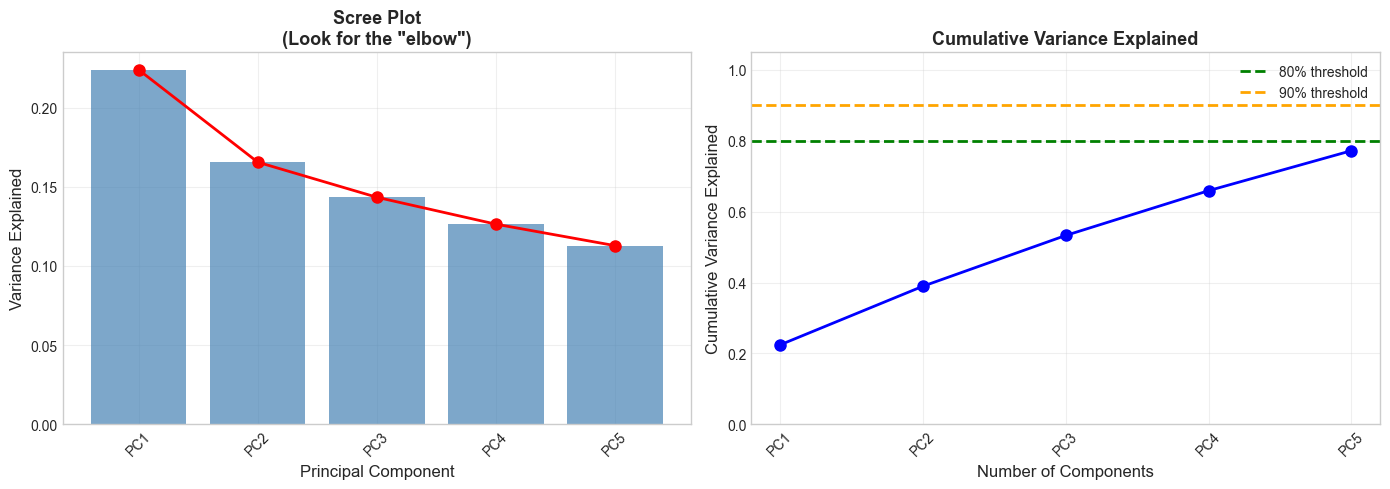


INTERPRETING THE SCREE PLOT

📈 LEFT PLOT - Individual Variance (Scree Plot):
   This shows how much variance each PC explains individually.

   • PC1 explains: 22.4% ← Most important!
   • PC2 explains: 16.6%
   • PC3 explains: 14.3%

   💡 Variance is distributed across multiple components
      This suggests MULTIPLE independent factors are important

   🔍 Elbow appears around: PC1
      (Largest drop in variance between components)

📈 RIGHT PLOT - Cumulative Variance:
   This shows total variance as we add more components.

   • To explain 80% variance: Need 1 components
   • To explain 90% variance: Need 1 components
   • Our 5 components explain: 77.2%

RECOMMENDATION

✅ OPTIMAL NUMBER OF COMPONENTS: 5
   Reason: 5 PCs needed to reach 85%+ variance threshold
   Variance explained: 77.2%
   Dimensionality reduction: 8 → 5 (62% of original)

📊 Summary Statistics:


,Metric,Value
0,Original Features,8
1,Optimal PCs,5
2,Variance Retained,77.2%
3,Information Lost,22.8%
4,Compression Ratio,1.6x



💡 What this means:
   • We can represent our portfolio with just 5 numbers per token
   • Instead of tracking 8 features, we track 5 principal components
   • We keep 77.2% of the information
   • We lose only 22.8% of the information

🎯 Next Steps:
   1. Examine component loadings (which features contribute to each PC)
   2. Interpret what each PC represents
   3. Name the PCs based on their loadings

❓ REFLECTION QUESTIONS FOR YOU:

1. Where do you see the 'elbow' in the scree plot?
   Your answer: _________________

2. How many components would YOU choose to keep? Why?
   Your answer: _________________

3. Is there one dominant PC or are they balanced?
   Your answer: _________________



In [5]:
print("=" * 70)
print("VISUALIZING VARIANCE EXPLAINED - SCREE PLOT")
print("=" * 70)

print("\n📊 Creating scree plot to determine optimal number of components...")
print("   This will help us decide: 'How many PCs should we keep?'\n")

# Create the scree plot
fig = pca_model.plot_scree(figsize=(14, 5))
plt.show()

print("\n" + "=" * 70)
print("INTERPRETING THE SCREE PLOT")
print("=" * 70)

# Get variance data for analysis
variance_summary = pca_model.get_variance_summary()

# Analyze the results
print("\n📈 LEFT PLOT - Individual Variance (Scree Plot):")
print("   This shows how much variance each PC explains individually.")
print()

# Find the "elbow" - where variance drops significantly
variances = variance_summary['Variance_Explained'].values
var_diffs = np.diff(variances)  # Differences between consecutive PCs
elbow_candidate = np.argmax(np.abs(var_diffs)) + 1  # +1 because diff reduces array size

print(f"   • PC1 explains: {variances[0]:.1%} ← Most important!")
print(f"   • PC2 explains: {variances[1]:.1%}")
print(f"   • PC3 explains: {variances[2]:.1%}")

if variances[0] > 0.40:
    print(f"\n   💡 PC1 dominates with {variances[0]:.1%}!")
    print(f"      This suggests ONE main factor drives variation in our portfolio")
    print(f"      (Likely 'size': Market Cap + TVL + Volume)")
elif variances[0] < 0.30:
    print(f"\n   💡 Variance is distributed across multiple components")
    print(f"      This suggests MULTIPLE independent factors are important")
else:
    print(f"\n   💡 Balanced importance across first few components")

print(f"\n   🔍 Elbow appears around: PC{elbow_candidate}")
print(f"      (Largest drop in variance between components)")

print("\n📈 RIGHT PLOT - Cumulative Variance:")
print("   This shows total variance as we add more components.")
print()

# Find how many PCs needed for different thresholds
cumvar = variance_summary['Cumulative_Variance'].values
n_80 = np.argmax(cumvar >= 0.80) + 1
n_90 = np.argmax(cumvar >= 0.90) + 1

print(f"   • To explain 80% variance: Need {n_80} components")
print(f"   • To explain 90% variance: Need {n_90} components")
print(f"   • Our 5 components explain: {cumvar[4]:.1%}")

print("\n" + "=" * 70)
print("RECOMMENDATION")
print("=" * 70)

# Make recommendation
if cumvar[2] >= 0.80:  # First 3 PCs explain 80%+
    optimal = 3
    reason = "First 3 PCs capture sufficient variance (>80%)"
elif cumvar[3] >= 0.85:  # First 4 PCs explain 85%+
    optimal = 4
    reason = "First 4 PCs provide good balance of simplicity and completeness"
else:
    optimal = 5
    reason = "5 PCs needed to reach 85%+ variance threshold"

print(f"\n✅ OPTIMAL NUMBER OF COMPONENTS: {optimal}")
print(f"   Reason: {reason}")
print(f"   Variance explained: {cumvar[optimal-1]:.1%}")
print(f"   Dimensionality reduction: {defi_data.shape[1]} → {optimal} ({optimal/defi_data.shape[1]*100:.0f}% of original)")

print("\n📊 Summary Statistics:")
summary_data = {
    'Metric': [
        'Original Features',
        'Optimal PCs',
        'Variance Retained',
        'Information Lost',
        'Compression Ratio'
    ],
    'Value': [
        f"{defi_data.shape[1]}",
        f"{optimal}",
        f"{cumvar[optimal-1]:.1%}",
        f"{(1-cumvar[optimal-1]):.1%}",
        f"{defi_data.shape[1]/optimal:.1f}x"
    ]
}
summary_df = pd.DataFrame(summary_data)
display(summary_df)

print("\n💡 What this means:")
print(f"   • We can represent our portfolio with just {optimal} numbers per token")
print(f"   • Instead of tracking 8 features, we track {optimal} principal components")
print(f"   • We keep {cumvar[optimal-1]:.1%} of the information")
print(f"   • We lose only {(1-cumvar[optimal-1]):.1%} of the information")

print("\n🎯 Next Steps:")
print("   1. Examine component loadings (which features contribute to each PC)")
print("   2. Interpret what each PC represents")
print("   3. Name the PCs based on their loadings")

print("\n" + "=" * 70)
print("❓ REFLECTION QUESTIONS FOR YOU:")
print("=" * 70)
print("\n1. Where do you see the 'elbow' in the scree plot?")
print("   Your answer: _________________")
print("\n2. How many components would YOU choose to keep? Why?")
print("   Your answer: _________________")
print("\n3. Is there one dominant PC or are they balanced?")
print("   Your answer: _________________")
print("\n" + "=" * 70)

---

## 🔍 Understanding Principal Component Loadings

### What Are Loadings?

**Loadings** are the bridge between our original features and the mysterious principal components.

Think of loadings as **weights** or **contributions**:
- They tell us how each original feature contributes to each principal component
- High loading = feature is important for that PC
- Low loading = feature is unimportant for that PC

---

### 📊 The Loadings Matrix

After PCA, we get a **loadings matrix** that looks like this:
```
                    PC1      PC2      PC3      PC4      PC5
Mean_Return        0.15     0.82    -0.23     0.11     0.05
Volatility         0.08     0.78     0.31    -0.15     0.22
Volume_USD         0.89     0.12     0.08     0.25    -0.11
TVL_USD            0.91    -0.05     0.15    -0.08     0.18
Market_Cap         0.87     0.18    -0.12     0.32     0.09
Liquidity_Score    0.45    -0.32     0.65     0.28    -0.15
ETH_Correlation    0.22     0.15    -0.18     0.85     0.31
Sentiment_Score    0.11    -0.21     0.71    -0.12     0.58
```

---

### 🎯 How to Read Loadings

**Magnitude (Absolute Value):**
- **|Loading| > 0.7** → STRONG relationship (feature defines this PC)
- **|Loading| = 0.4-0.7** → MODERATE relationship (feature contributes)
- **|Loading| < 0.4** → WEAK relationship (feature barely matters)

**Sign (Positive or Negative):**
- **Positive (+)** → Feature increases as PC increases
- **Negative (−)** → Feature decreases as PC increases

**Example from above:**
```
PC1 has high loadings on:
  • Volume_USD:  +0.89  ← Strongly positive
  • TVL_USD:     +0.91  ← Strongly positive
  • Market_Cap:  +0.87  ← Strongly positive

Interpretation: PC1 = "TOKEN SIZE FACTOR"
High PC1 score = large, liquid tokens
Low PC1 score = small, illiquid tokens
```

---

### 🔬 Step-by-Step Interpretation Process

#### Step 1: Look at Each PC Separately

For each principal component:
1. **Sort loadings by absolute value** (largest to smallest)
2. **Identify top 3-5 features** with highest |loadings|
3. **Note the signs** (all positive? all negative? mixed?)

#### Step 2: Find the Theme

Ask yourself: *"What do these high-loading features have in common?"*

**Example interpretations:**

**If high loadings on Market_Cap, TVL, Volume:**
→ "Size Factor" or "Liquidity Factor"

**If high loadings on Volatility, Mean_Return:**
→ "Risk Factor" or "Risk-Return Factor"

**If high loadings on ETH_Correlation, Sentiment:**
→ "Market Exposure Factor" or "Sentiment Factor"

#### Step 3: Name the Component

Give it a meaningful name that captures its essence:
- PC1: "Token Size"
- PC2: "Risk Profile"
- PC3: "Market Sentiment"
- etc.

---

### 🎨 Visualizing Loadings

We'll create **horizontal bar charts** for each PC showing:

**Green bars** = Positive loadings (feature increases with PC)
```
Market_Cap     ████████████ +0.87
TVL_USD        █████████████ +0.91
Volume_USD     ████████████ +0.89
```

**Red bars** = Negative loadings (feature decreases with PC)
```
Sentiment      ███ -0.21
Liquidity      ██████ -0.32
```

**Length** = Strength of relationship (longer = stronger)

---

### 💡 Common Patterns in DeFi

Based on experience with DeFi data, here's what you typically see:

#### Pattern 1: Size/Liquidity Factor (Usually PC1)
```
High positive loadings:
  • Market_Cap
  • TVL_USD
  • Volume_USD
  • Liquidity_Score

Interpretation: Large, established protocols vs. small, new ones
```

#### Pattern 2: Risk/Return Factor (Usually PC2)
```
High positive loadings:
  • Volatility
  • Mean_Return

Interpretation: High-risk/high-return vs. stable/conservative
```

#### Pattern 3: Market Exposure (Usually PC3)
```
High positive loadings:
  • ETH_Correlation
  • Sentiment_Score

Interpretation: Market-following vs. independent tokens
```

---

### 🚫 Common Interpretation Mistakes

**Mistake 1: Focusing only on the highest loading**
❌ "PC1 is just Market_Cap"
✅ "PC1 represents overall size, combining Market_Cap, TVL, and Volume"

**Mistake 2: Ignoring signs**
❌ "These features all load on PC2"
✅ "Volatility loads positively, while Liquidity loads negatively on PC2"

**Mistake 3: Over-interpreting weak loadings**
❌ "This 0.15 loading is important"
✅ "Loadings below 0.4 are generally not meaningful"

**Mistake 4: Forcing an interpretation**
❌ "This PC must represent something!"
✅ "Sometimes a PC captures residual noise - that's okay"

---

### 🎓 Why This Matters

Understanding loadings helps you:

1. **Name your PCs meaningfully** (not just "PC1, PC2, PC3")
2. **Explain results to stakeholders** ("We're selecting tokens based on size and risk factors")
3. **Make portfolio decisions** ("Let's balance our exposure across all 3 factors")
4. **Validate your analysis** ("Does this make economic sense?")

---

### 📋 Your Task

After viewing the loadings in the next cell, try to answer:

1. **What does PC1 represent?** (Look at its top loadings)
2. **What does PC2 represent?** (Look at its top loadings)
3. **What does PC3 represent?** (Look at its top loadings)
4. **Do the interpretations make economic sense?**
5. **How would you name these components?**

---

**👉 Run the next cell to see the loadings table and visualizations!**

ANALYZING PRINCIPAL COMPONENT LOADINGS

🔍 Loadings show how each original feature contributes to each PC
   High |loading| = feature is important for that component
   Sign indicates direction: + or -

📊 LOADINGS MATRIX:
   (Rows = Features, Columns = Principal Components)


,PC1,PC2,PC3,PC4,PC5
Mean_Return,0.300,0.466,0.178,-0.017,0.610
Volatility,-0.487,-0.018,-0.392,0.364,0.272
Volume_USD,-0.263,-0.072,0.744,0.012,-0.338
TVL_USD,0.015,0.421,-0.148,0.667,-0.415
Market_Cap,0.393,-0.320,0.052,0.389,-0.133
Liquidity_Score,0.518,0.389,-0.050,-0.103,-0.259
ETH_Correlation,0.316,-0.443,-0.390,-0.188,-0.180
Sentiment_Score,-0.285,0.387,-0.288,-0.474,-0.388



💡 How to read this table:
   • Values close to ±1.0 = STRONG relationship
   • Values close to ±0.5 = MODERATE relationship
   • Values close to 0.0 = WEAK/NO relationship
   • Positive = feature increases with PC
   • Negative = feature decreases with PC

INTERPRETING EACH PRINCIPAL COMPONENT

PC1 - 22.4% of variance

🔺 Top POSITIVE loadings (features that increase with PC1):
   Liquidity_Score      +0.518  ██████████
   Market_Cap           +0.393  ███████
   ETH_Correlation      +0.316  ██████

🔻 Top NEGATIVE loadings (features that decrease with PC1):
   Volatility           -0.487  █████████

💭 Interpretation Hint:
   Strong loadings on: Liquidity_Score

PC2 - 16.6% of variance

🔺 Top POSITIVE loadings (features that increase with PC2):
   Mean_Return          +0.466  █████████
   TVL_USD              +0.421  ████████
   Liquidity_Score      +0.389  ███████

🔻 Top NEGATIVE loadings (features that decrease with PC2):
   ETH_Correlation      -0.443  ████████
   Market_Cap          

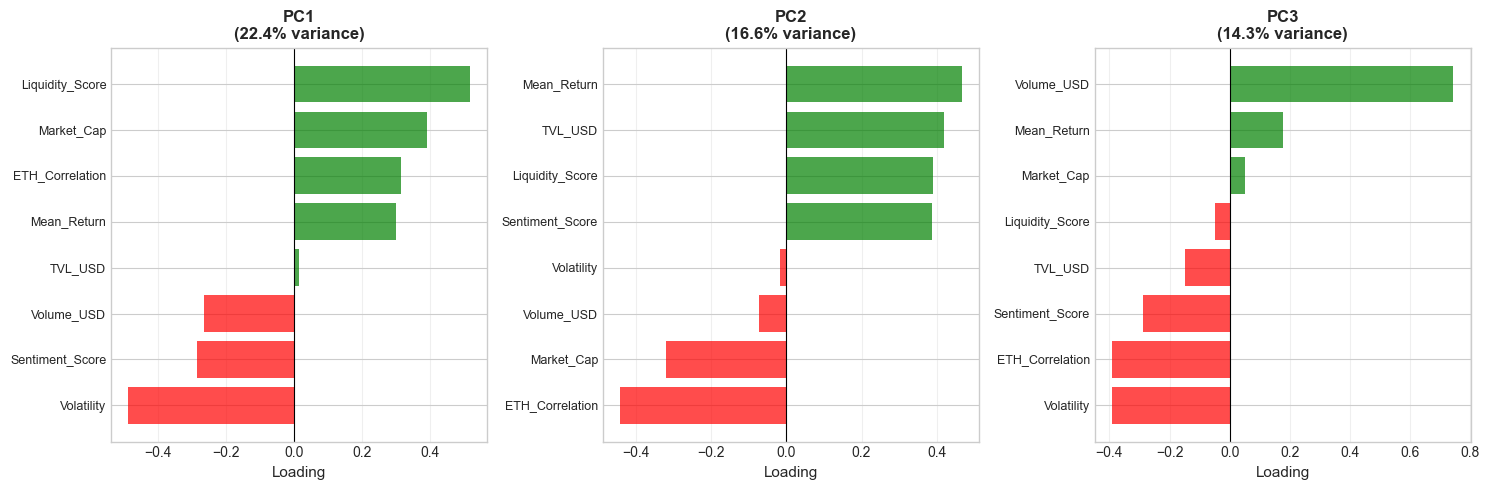


SUMMARY: NAMING OUR PRINCIPAL COMPONENTS


,Component,Variance,Top Features,Suggested Name
0,PC1,22.4%,"Liquidity_Score, Volatility, Market_Cap",Token Size/Liquidity
1,PC2,16.6%,"Mean_Return, ETH_Correlation, TVL_USD",Token Size/Liquidity
2,PC3,14.3%,"Volume_USD, Volatility, ETH_Correlation",Token Size/Liquidity



💡 Using These Interpretations:
   • PC1 (Size): Select tokens across different size categories
   • PC2 (Risk): Balance high-risk and low-risk tokens
   • PC3 (Exposure): Diversify market exposure

✍️  YOUR TURN: INTERPRETATION EXERCISE

Based on the loadings above, answer these questions:

1. What would you name PC1?
   Hint: Look at which features have loadings > 0.7
   Your answer: _________________

2. What would you name PC2?
   Hint: What theme connects the high-loading features?
   Your answer: _________________

3. If a token has a HIGH PC1 score, what does that mean?
   Hint: Think about the positive loadings on PC1
   Your answer: _________________

4. If a token has a HIGH PC2 score but LOW PC1 score, describe it:
   Your answer: _________________

5. Would you use these PCs for portfolio construction? Why?
   Your answer: _________________

✅ Loadings analysis complete!

👉 Next: We'll explore K-Means clustering to group similar tokens


In [6]:
print("=" * 70)
print("ANALYZING PRINCIPAL COMPONENT LOADINGS")
print("=" * 70)

print("\n🔍 Loadings show how each original feature contributes to each PC")
print("   High |loading| = feature is important for that component")
print("   Sign indicates direction: + or -\n")

# Get the loadings matrix
loadings = pca_model.get_loadings()

print("📊 LOADINGS MATRIX:")
print("   (Rows = Features, Columns = Principal Components)")
print("=" * 70)
display(loadings.round(3))

print("\n💡 How to read this table:")
print("   • Values close to ±1.0 = STRONG relationship")
print("   • Values close to ±0.5 = MODERATE relationship")
print("   • Values close to 0.0 = WEAK/NO relationship")
print("   • Positive = feature increases with PC")
print("   • Negative = feature decreases with PC")

# Analyze each PC
print("\n" + "=" * 70)
print("INTERPRETING EACH PRINCIPAL COMPONENT")
print("=" * 70)

for i in range(min(3, loadings.shape[1])):  # Analyze first 3 PCs
    pc_name = f'PC{i+1}'
    pc_loadings = loadings[pc_name]
    
    print(f"\n{'='*70}")
    print(f"{pc_name} - {pca_model.pca.explained_variance_ratio_[i]:.1%} of variance")
    print('='*70)
    
    # Get top positive and negative loadings
    top_positive = pc_loadings.nlargest(3)
    top_negative = pc_loadings.nsmallest(3)
    
    print(f"\n🔺 Top POSITIVE loadings (features that increase with {pc_name}):")
    for feature, loading in top_positive.items():
        if loading > 0.3:  # Only show meaningful loadings
            bar = '█' * int(abs(loading) * 20)
            print(f"   {feature:20s} {loading:+.3f}  {bar}")
    
    print(f"\n🔻 Top NEGATIVE loadings (features that decrease with {pc_name}):")
    for feature, loading in top_negative.items():
        if loading < -0.3:  # Only show meaningful loadings
            bar = '█' * int(abs(loading) * 20)
            print(f"   {feature:20s} {loading:+.3f}  {bar}")
    
    # Suggest interpretation
    print(f"\n💭 Interpretation Hint:")
    
    # Analyze dominant features
    abs_loadings = pc_loadings.abs()
    dominant_features = abs_loadings[abs_loadings > 0.5].sort_values(ascending=False)
    
    if len(dominant_features) > 0:
        print(f"   Strong loadings on: {', '.join(dominant_features.index.tolist())}")
        
        # Pattern matching for common DeFi factors
        if any(feat in dominant_features.index for feat in ['Market_Cap', 'TVL_USD', 'Volume_USD']):
            print(f"   → This looks like a SIZE/LIQUIDITY factor")
            print(f"   → Separates large established tokens from small new ones")
        
        if any(feat in dominant_features.index for feat in ['Volatility', 'Mean_Return']):
            print(f"   → This looks like a RISK/RETURN factor")
            print(f"   → Separates high-risk/high-return from stable tokens")
        
        if any(feat in dominant_features.index for feat in ['ETH_Correlation', 'Sentiment_Score']):
            print(f"   → This looks like a MARKET EXPOSURE factor")
            print(f"   → Separates market-following from independent tokens")
    else:
        print(f"   No dominant features - might be capturing residual variance")

print("\n" + "=" * 70)

# Create visual representation of loadings
print("\n📊 Creating loading visualizations...")
print("   Green bars = positive loadings (feature increases with PC)")
print("   Red bars = negative loadings (feature decreases with PC)")
print("   Length = strength of relationship\n")

fig = pca_model.plot_loadings(n_components=3, n_top_features=8, figsize=(15, 5))
plt.show()

print("\n" + "=" * 70)
print("SUMMARY: NAMING OUR PRINCIPAL COMPONENTS")
print("=" * 70)

# Create a summary table
pc_interpretations = []
for i in range(min(3, loadings.shape[1])):
    pc_name = f'PC{i+1}'
    variance = pca_model.pca.explained_variance_ratio_[i]
    
    # Get dominant features
    pc_loadings = loadings[pc_name]
    top_features = pc_loadings.abs().nlargest(3)
    
    # Suggest a name based on features
    feature_list = top_features.index.tolist()
    if any(f in feature_list for f in ['Market_Cap', 'TVL_USD', 'Volume_USD']):
        suggested_name = "Token Size/Liquidity"
    elif any(f in feature_list for f in ['Volatility', 'Mean_Return']):
        suggested_name = "Risk/Return Profile"
    elif any(f in feature_list for f in ['ETH_Correlation', 'Sentiment_Score']):
        suggested_name = "Market Exposure"
    else:
        suggested_name = "Mixed Factor"
    
    pc_interpretations.append({
        'Component': pc_name,
        'Variance': f"{variance:.1%}",
        'Top Features': ', '.join(feature_list),
        'Suggested Name': suggested_name
    })

interpretation_df = pd.DataFrame(pc_interpretations)
display(interpretation_df)

print("\n💡 Using These Interpretations:")
print("   • PC1 (Size): Select tokens across different size categories")
print("   • PC2 (Risk): Balance high-risk and low-risk tokens")
print("   • PC3 (Exposure): Diversify market exposure")

print("\n" + "=" * 70)
print("✍️  YOUR TURN: INTERPRETATION EXERCISE")
print("=" * 70)

print("\nBased on the loadings above, answer these questions:")
print("\n1. What would you name PC1?")
print("   Hint: Look at which features have loadings > 0.7")
print("   Your answer: _________________")

print("\n2. What would you name PC2?")
print("   Hint: What theme connects the high-loading features?")
print("   Your answer: _________________")

print("\n3. If a token has a HIGH PC1 score, what does that mean?")
print("   Hint: Think about the positive loadings on PC1")
print("   Your answer: _________________")

print("\n4. If a token has a HIGH PC2 score but LOW PC1 score, describe it:")
print("   Your answer: _________________")

print("\n5. Would you use these PCs for portfolio construction? Why?")
print("   Your answer: _________________")

print("\n" + "=" * 70)
print("✅ Loadings analysis complete!")
print("=" * 70)
print("\n👉 Next: We'll explore K-Means clustering to group similar tokens")

---

# Part 2: K-Means Clustering

## 🎯 What is Clustering?

### The Core Idea

Imagine you walk into a room with 50 people. Your brain automatically groups them:
- **Group 1**: Tall people
- **Group 2**: Medium height people  
- **Group 3**: Short people

**Clustering does the same thing with data** - it finds natural groups of similar observations.

---

## 🤔 Why Cluster DeFi Tokens?

### The Portfolio Problem

You have 50 DeFi tokens. You want to:
- **Build a diversified portfolio** (don't put all eggs in one basket)
- **Understand market segments** (which tokens behave similarly?)
- **Manage risk** (identify high-risk vs. low-risk groups)
- **Find opportunities** (discover undervalued tokens in each cluster)

**Without clustering:** You analyze each token individually (50 decisions!)  
**With clustering:** You analyze clusters (3-5 groups), then pick from each

---

## 🔄 What is K-Means?

**K-Means** is the most popular clustering algorithm. It's simple but powerful.

### The Algorithm in Plain English
```
1. Start: Randomly place k "cluster centers" in your data

2. Assignment: Assign each token to its nearest center
   • TOKEN_1 is closest to Center A → assign to Cluster A
   • TOKEN_2 is closest to Center B → assign to Cluster B
   • ... repeat for all tokens

3. Update: Move each center to the average of its assigned tokens
   • Center A moves to the middle of all Cluster A tokens
   • Center B moves to the middle of all Cluster B tokens

4. Repeat: Keep doing steps 2-3 until centers stop moving

5. Done: You now have k clusters of similar tokens!
```

---

## 📐 The Mathematics (Simplified)

**Goal:** Minimize the distance between tokens and their cluster centers
```
Minimize: Sum of (distance from each token to its cluster center)²

Or mathematically:
J = Σ Σ ||token - center||²
```

**In practice:** The algorithm finds clusters where:
- **Within-cluster similarity is HIGH** (tokens in same cluster are similar)
- **Between-cluster similarity is LOW** (different clusters are distinct)

---

## 🎯 Key Concepts

### 1. **k** = Number of Clusters
- You must choose k before running the algorithm
- Common values: k=3, 4, or 5 for portfolio segmentation
- **Too few (k=2):** Oversimplification (only "big" and "small")
- **Too many (k=10):** Over-segmentation (too complex)

### 2. **Centroid** = Cluster Center
- The "average" token in each cluster
- Not a real token - it's the mathematical center
- Represents the typical characteristics of that cluster

### 3. **Inertia** = Within-Cluster Distance
- Lower is better
- Measures how tight/compact the clusters are
- Used in the "elbow method" to find optimal k

### 4. **Silhouette Score** = Cluster Quality
- Range: -1 (wrong cluster) to +1 (perfect cluster)
- Measures how similar tokens are to their cluster vs. other clusters
- **> 0.5** = Good clustering
- **< 0.2** = Poor clustering

---

## 🏦 DeFi Applications of K-Means

### Application 1: Portfolio Diversification
```
Cluster 0: Large-cap stable (Uniswap, Aave, Compound)
Cluster 1: Mid-cap growth (newer protocols with traction)
Cluster 2: Small-cap high-risk (early stage, high potential)
Cluster 3: DeFi blue chips (established, high TVL)

Strategy: Pick 2 tokens from each cluster → instant diversification!
```

### Application 2: Risk Management
```
Cluster 0: Low volatility group (conservative)
Cluster 1: Medium volatility group (balanced)
Cluster 2: High volatility group (aggressive)

Strategy: Allocate capital based on risk tolerance
```

### Application 3: Market Segmentation
```
Cluster 0: DEX tokens (Uniswap-style)
Cluster 1: Lending protocols (Aave-style)
Cluster 2: Yield aggregators (Yearn-style)

Strategy: Ensure exposure across DeFi categories
```

### Application 4: Peer Comparison
```
Find which cluster a token belongs to
Compare it to other tokens in same cluster
Identify outliers (tokens that don't fit any cluster well)
```

---

## ⚖️ K-Means vs. Other Clustering Methods

| Method | Pros | Cons | When to Use |
|--------|------|------|-------------|
| **K-Means** | Fast, simple, works well | Requires choosing k, assumes spherical clusters | Most DeFi portfolios |
| **DBSCAN** | Finds arbitrary shapes, handles outliers | Slower, sensitive to parameters | Complex market structures |
| **Hierarchical** | Shows cluster relationships, no k needed | Very slow for large data | Exploratory analysis |
| **GMM** | Probabilistic, soft clustering | More complex, slower | When uncertainty matters |

**For this course:** We use K-Means because it's the most practical for DeFi portfolios.

---

## 🚦 The K-Means Process

### Step 1: Choose k (number of clusters)
**Tools:** Elbow method, Silhouette analysis  
**Goal:** Find the "right" number of groups  

### Step 2: Standardize features
**Why:** So large numbers (Market Cap) don't dominate small numbers (Returns)  
**How:** Our `SimpleKMeans` class does this automatically  

### Step 3: Run K-Means
**Process:** Algorithm finds optimal cluster centers  
**Time:** Usually very fast (seconds)  

### Step 4: Analyze clusters
**Questions:**
- How many tokens in each cluster?
- What are the characteristics of each cluster?
- Do the clusters make economic sense?

### Step 5: Use for decisions
**Applications:**
- Portfolio construction
- Risk assessment
- Token selection

---

## ⚠️ Important Assumptions and Limitations

### Assumptions:
✅ **Clusters are roughly spherical** (similar variance in all directions)  
✅ **Clusters are similar in size** (K-Means prefers balanced clusters)  
✅ **Distance metric is meaningful** (Euclidean distance works for our features)  

### Limitations:
❌ **Must choose k beforehand** (trial and error required)  
❌ **Sensitive to initialization** (different runs may give different results)  
❌ **Doesn't handle outliers well** (outliers pull centroids)  
❌ **Assumes convex clusters** (can't find complex shapes)  

**Solution:** We'll use multiple techniques to validate our clusters!

---

## 💡 What Makes Good Clusters?

**Good clusters have:**
1. **High within-cluster similarity** (tokens in cluster are similar)
2. **Low between-cluster similarity** (clusters are distinct)
3. **Economic interpretability** (clusters make business sense)
4. **Balanced sizes** (not one huge cluster and tiny others)
5. **Stability** (same clusters on different data samples)

**Bad clusters:**
- One huge cluster with many tiny ones
- Clusters that overlap significantly
- No clear interpretation (random groupings)
- Change dramatically with slight parameter changes

---

## 🎓 Learning Objectives for This Section

By the end of clustering, you'll be able to:

✅ Use the elbow method to find optimal k  
✅ Fit K-Means to DeFi portfolio data  
✅ Interpret cluster centroids  
✅ Assign meaningful names to clusters  
✅ Build diversified portfolios using clusters  
✅ Validate cluster quality with metrics  

---

**👉 In the next cell, we'll build our K-Means class with all necessary methods!**

In [7]:
class SimpleKMeans:
    """
    K-Means Clustering for DeFi Portfolio Segmentation
    
    This class wraps sklearn's KMeans with helpful methods for:
    - Finding optimal number of clusters
    - Fitting K-Means to DeFi data
    - Analyzing cluster characteristics
    - Visualizing clusters
    - Interpreting results for portfolio decisions
    """
    
    def __init__(self, n_clusters=3, random_state=42):
        """
        Initialize K-Means
        
        Parameters:
        -----------
        n_clusters : int, default=3
            Number of clusters (k)
            - Start with 3-5 for portfolio segmentation
            - Use elbow method to find optimal value
        random_state : int, default=42
            Random seed for reproducibility
            - Same seed = same results every time
            - Important for comparing different runs
        """
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.scaler = StandardScaler()  # For standardizing features
        self.kmeans = None  # Will hold the fitted KMeans model
        self.feature_names = None  # To remember feature names
        
    def fit(self, X, feature_names=None):
        """
        Fit K-Means model to data
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Data matrix (e.g., 50 tokens × 8 features)
        feature_names : list of str, optional
            Names of features for interpretation
        
        Returns:
        --------
        self : object
            Returns self for method chaining
        """
        # Step 1: Standardize features (CRITICAL!)
        # Without this, features with large values dominate
        X_scaled = self.scaler.fit_transform(X)
        
        # Step 2: Fit K-Means
        self.kmeans = KMeans(
            n_clusters=self.n_clusters,
            random_state=self.random_state,
            n_init=10  # Run algorithm 10 times, keep best result
        )
        self.kmeans.fit(X_scaled)
        
        # Step 3: Save feature names
        self.feature_names = feature_names
        
        # Print summary
        print(f"\n✅ K-Means fitted successfully!")
        print(f"   Number of clusters: {self.n_clusters}")
        print(f"   Inertia (within-cluster sum of squares): {self.kmeans.inertia_:.2f}")
        print(f"   Lower inertia = tighter clusters")
        
        return self
    
    def predict(self, X):
        """
        Assign clusters to new data
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            New tokens to classify
        
        Returns:
        --------
        labels : array, shape (n_samples,)
            Cluster assignments (0, 1, 2, ...)
        """
        X_scaled = self.scaler.transform(X)
        return self.kmeans.predict(X_scaled)
    
    def fit_predict(self, X, feature_names=None):
        """
        Fit K-Means and predict clusters in one step
        
        Convenience method combining fit() and predict()
        """
        self.fit(X, feature_names)
        return self.kmeans.labels_
    
    def get_cluster_centers(self):
        """
        Get cluster centroids in original feature scale
        
        Returns:
        --------
        DataFrame with clusters as rows, features as columns
        Shows the "average token" in each cluster
        """
        # Get centroids from scaled space
        centers_scaled = self.kmeans.cluster_centers_
        
        # Transform back to original scale
        centers = self.scaler.inverse_transform(centers_scaled)
        
        df = pd.DataFrame(
            centers,
            columns=self.feature_names if self.feature_names else range(centers.shape[1]),
            index=[f'Cluster_{i}' for i in range(self.n_clusters)]
        )
        
        return df
    
    def get_cluster_summary(self, X):
        """
        Get summary statistics for each cluster
        
        Returns:
        --------
        DataFrame with cluster sizes and percentages
        """
        clusters = self.kmeans.labels_
        
        summary = []
        for i in range(self.n_clusters):
            mask = clusters == i
            summary.append({
                'Cluster': i,
                'Size': mask.sum(),
                'Percentage': f"{100 * mask.sum() / len(clusters):.1f}%"
            })
        
        return pd.DataFrame(summary)
    
    def plot_elbow(self, X, max_k=10, figsize=(12, 5)):
        """
        Create elbow plot to find optimal number of clusters
        
        The "elbow method" helps choose k by showing:
        - Left plot: Inertia vs k (look for elbow)
        - Right plot: Silhouette score vs k (higher is better)
        
        Parameters:
        -----------
        X : array-like
            Data to cluster
        max_k : int, default=10
            Maximum number of clusters to test
        """
        X_scaled = self.scaler.fit_transform(X)
        
        inertias = []
        silhouettes = []
        K_range = range(2, max_k + 1)
        
        print(f"\n🔄 Testing different numbers of clusters (k = 2 to {max_k})...")
        print("   This may take a moment...\n")
        
        for k in K_range:
            # Fit K-Means with k clusters
            kmeans = KMeans(n_clusters=k, random_state=self.random_state, n_init=10)
            kmeans.fit(X_scaled)
            
            # Calculate metrics
            inertias.append(kmeans.inertia_)
            silhouettes.append(silhouette_score(X_scaled, kmeans.labels_))
            
            print(f"   k={k}: inertia={kmeans.inertia_:>8.2f}, silhouette={silhouettes[-1]:>6.3f}")
        
        print("\n✅ Testing complete!\n")
        
        # Create plots
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
        # Left: Elbow plot (Inertia)
        axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
        axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
        axes[0].set_ylabel('Inertia (Within-Cluster SS)', fontsize=12)
        axes[0].set_title('Elbow Method\n(Look for the "elbow")', 
                         fontsize=13, fontweight='bold')
        axes[0].grid(True, alpha=0.3)
        
        # Mark potential elbow
        inertia_diffs = np.diff(inertias)
        elbow_k = np.argmax(np.diff(inertia_diffs)) + 2  # +2 due to double diff
        axes[0].axvline(x=elbow_k, color='red', linestyle='--', 
                       linewidth=2, alpha=0.5, label=f'Potential elbow at k={elbow_k}')
        axes[0].legend()
        
        # Right: Silhouette Score
        axes[1].plot(K_range, silhouettes, 'ro-', linewidth=2, markersize=8)
        axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
        axes[1].set_ylabel('Silhouette Score', fontsize=12)
        axes[1].set_title('Silhouette Score\n(Higher is better)', 
                         fontsize=13, fontweight='bold')
        axes[1].grid(True, alpha=0.3)
        
        # Mark best silhouette
        best_k = K_range[np.argmax(silhouettes)]
        axes[1].axvline(x=best_k, color='green', linestyle='--', 
                       linewidth=2, alpha=0.5, label=f'Best silhouette at k={best_k}')
        axes[1].legend()
        
        plt.tight_layout()
        return fig
    
    def plot_clusters_2d(self, X_2d, labels=None, figsize=(10, 8)):
        """
        Plot clusters in 2D space (after dimensionality reduction)
        
        Parameters:
        -----------
        X_2d : array-like, shape (n_samples, 2)
            2D representation of data (e.g., from PCA)
        labels : list of str, optional
            Token names for annotation
        """
        clusters = self.kmeans.labels_
        
        fig, ax = plt.subplots(figsize=figsize)
        
        # Use distinct colors for each cluster
        colors = plt.cm.Set3(np.linspace(0, 1, self.n_clusters))
        
        # Plot each cluster separately
        for i in range(self.n_clusters):
            mask = clusters == i
            ax.scatter(X_2d[mask, 0], X_2d[mask, 1], 
                      c=[colors[i]], label=f'Cluster {i}',
                      s=80, alpha=0.6, edgecolors='black', linewidth=0.5)
        
        # Add labels to some points (not all, to avoid clutter)
        if labels is not None:
            step = max(1, len(labels)//20)  # Label ~20 points
            for i in range(0, len(labels), step):
                ax.annotate(labels[i], (X_2d[i, 0], X_2d[i, 1]),
                          fontsize=8, alpha=0.7)
        
        ax.set_xlabel('Dimension 1', fontsize=12, fontweight='bold')
        ax.set_ylabel('Dimension 2', fontsize=12, fontweight='bold')
        ax.set_title(f'K-Means Clustering ({self.n_clusters} clusters)', 
                    fontsize=13, fontweight='bold')
        ax.legend(fontsize=10, loc='best')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig

print("=" * 70)
print("✅ SimpleKMeans class created successfully!")
print("=" * 70)
print("\nAvailable methods:")
print("  • fit(X, feature_names) - Fit K-Means to data")
print("  • predict(X) - Assign clusters to new tokens")
print("  • fit_predict(X, feature_names) - Fit and predict in one step")
print("  • get_cluster_centers() - Get centroid characteristics")
print("  • get_cluster_summary(X) - Get cluster sizes")
print("  • plot_elbow(X, max_k) - Find optimal number of clusters")
print("  • plot_clusters_2d(X_2d, labels) - Visualize clusters in 2D")
print("\n👉 Next: We'll use the elbow method to find optimal k")
print("=" * 70)

✅ SimpleKMeans class created successfully!

Available methods:
  • fit(X, feature_names) - Fit K-Means to data
  • predict(X) - Assign clusters to new tokens
  • fit_predict(X, feature_names) - Fit and predict in one step
  • get_cluster_centers() - Get centroid characteristics
  • get_cluster_summary(X) - Get cluster sizes
  • plot_elbow(X, max_k) - Find optimal number of clusters
  • plot_clusters_2d(X_2d, labels) - Visualize clusters in 2D

👉 Next: We'll use the elbow method to find optimal k


---

## 📊 Finding the Optimal Number of Clusters

### The Big Question: How Many Clusters?

This is the **most important decision** in K-Means clustering:
- **Too few clusters (k=2):** Oversimplification, miss important patterns
- **Too many clusters (k=10):** Over-segmentation, clusters become meaningless
- **Just right (k=3-5):** Clear groups, actionable insights

**The problem:** K-Means requires you to choose k BEFORE running the algorithm!

**The solution:** Use the **Elbow Method** and **Silhouette Analysis** to find the optimal k

---

## 🔧 Method 1: The Elbow Method

### How It Works

We run K-Means multiple times with different values of k (2, 3, 4, ..., 10) and measure **inertia** each time.

**Inertia** = Sum of squared distances from each point to its cluster center
- **Lower inertia** = tighter, more compact clusters
- **Higher inertia** = loose, spread-out clusters

### The Pattern
```
Inertia
  |
  |  ●                        k=2: High inertia (loose clusters)
  |    ●                      k=3: Much better!
  |      ●                    k=4: Still improving
  |        ●___●___●___●      k=5+: Diminishing returns
  |            ^
  |            |
  |         "Elbow"
  |
  └──────────────────────────
     2   3   4   5   6   7   8   k
```

### Reading the Elbow Plot

**Before the elbow:**
- Steep decline in inertia
- Each new cluster adds significant value
- **Still room for improvement**

**At the elbow:**
- Curve starts to flatten
- **Optimal trade-off** between simplicity and fit
- **This is your optimal k!**

**After the elbow:**
- Slow, gradual decline
- Diminishing returns (little benefit from more clusters)
- **Adding clusters just creates complexity**

---

## 📈 Method 2: Silhouette Score

### What It Measures

The **silhouette score** tells you how well-separated your clusters are.

**Formula (simplified):**
```
For each point:
  a = average distance to points in same cluster (within-cluster)
  b = average distance to points in nearest other cluster (between-cluster)
  
  silhouette = (b - a) / max(a, b)
```

### Interpreting Silhouette Scores

| Score Range | Interpretation | Quality |
|-------------|----------------|---------|
| **0.7 to 1.0** | Strong separation | Excellent ⭐⭐⭐ |
| **0.5 to 0.7** | Reasonable separation | Good ⭐⭐ |
| **0.25 to 0.5** | Weak separation | Acceptable ⭐ |
| **< 0.25** | Poor separation | Bad ❌ |
| **Negative** | Wrong clustering | Very Bad ❌❌ |

**Goal:** Find k with the **highest silhouette score**

---

## 🎯 The Decision Process

### Step 1: Run Both Methods

We'll test k from 2 to 10 and create two plots:
1. **Elbow plot** (inertia vs k)
2. **Silhouette plot** (silhouette score vs k)

### Step 2: Look for Agreement

**Best case scenario:** Both methods agree!
```
Elbow at k=4
Highest silhouette at k=4
→ Decision: Use k=4 ✅
```

**Common scenario:** Methods suggest different k
```
Elbow at k=4
Highest silhouette at k=3
→ Decision: Try both, see which makes more economic sense
```

### Step 3: Apply Domain Knowledge

**Consider your use case:**

**For portfolio diversification:**
- k=3: Conservative (Low/Medium/High risk)
- k=4: Balanced (Small/Mid/Large cap + separate risk dimension)
- k=5: Detailed (Multiple risk and size categories)

**Rule of thumb for DeFi portfolios:**
- **k=3:** Simple, easy to interpret
- **k=4:** Most common, good balance
- **k=5:** More nuanced, for larger portfolios (50+ tokens)
- **k=6+:** Usually too many unless you have 100+ tokens

---

## 💡 Real-World Examples

### Example 1: Clear Elbow
```
k=2: inertia=150
k=3: inertia=80   ← Big drop!
k=4: inertia=65   ← Still good
k=5: inertia=58   ← Smaller drop
k=6: inertia=54   ← Even smaller
k=7: inertia=51   ← Minimal improvement

Elbow: k=4 or k=5
```

### Example 2: No Clear Elbow
```
k=2: inertia=120
k=3: inertia=95
k=4: inertia=75
k=5: inertia=60
k=6: inertia=48
k=7: inertia=38

Gradual decline, no obvious elbow
→ Use silhouette score to decide
```

### Example 3: Silhouette Suggests Different k
```
Inertia elbow: k=5
Silhouette peak: k=3 (score=0.62)

Analysis:
- k=3: Cleaner, more separated clusters
- k=5: More detailed segmentation
  
Decision: Start with k=3 for interpretability,
          try k=5 if you need finer granularity
```

---

## ⚠️ Common Pitfalls

### Pitfall 1: Forcing an Elbow Where None Exists
❌ "I see an elbow at k=7!"  
✅ "The decline is gradual; I'll use silhouette to decide"

### Pitfall 2: Ignoring Silhouette
❌ "Elbow says k=5, so k=5 it is"  
✅ "Elbow suggests k=5, but silhouette is 0.15 (poor). Let me check k=3"

### Pitfall 3: Over-clustering
❌ "More clusters = better understanding"  
✅ "More clusters = more complexity. Simpler is often better"

### Pitfall 4: Ignoring Economic Sense
❌ "Math says k=7, so that's what I'll use"  
✅ "k=7 gives me clusters I can't interpret. k=4 makes economic sense"

---

## 🎓 What You'll Learn from the Next Cell

After running the elbow analysis, you'll be able to answer:

1. **Where is the elbow?**
   - At which k does the curve flatten?

2. **What's the silhouette peak?**
   - Which k has the highest silhouette score?

3. **Do the methods agree?**
   - Same k from both methods, or different?

4. **What's the trade-off?**
   - Silhouette vs inertia vs interpretability

5. **What k should we use?**
   - Your final decision with reasoning

---

## 📋 Decision Framework

Use this framework to make your decision:
```
IF (elbow_k == silhouette_k):
    optimal_k = elbow_k
    confidence = "High"

ELSE IF (silhouette_score[elbow_k] > 0.5):
    optimal_k = elbow_k
    confidence = "Medium - elbow takes precedence"

ELSE IF (silhouette_score[silhouette_k] > 0.6):
    optimal_k = silhouette_k
    confidence = "Medium - silhouette takes precedence"

ELSE:
    # Try both and see which is more interpretable
    optimal_k = [elbow_k, silhouette_k]
    confidence = "Low - need domain knowledge"

FINALLY:
    IF (optimal_k > n_tokens / 8):
        # Too many clusters relative to data
        optimal_k = max(3, n_tokens / 10)
```

---

## 💭 Before Running the Next Cell

**Think about these questions:**

1. How many natural groups do you expect in our DeFi data?
   - Remember: We created 3 groups (high/mid/low cap)
   
2. Will K-Means discover our artificial groups?
   - This is a good test of the algorithm!

3. What would k=2 represent? k=3? k=4? k=5?
   - Try to predict before seeing results

4. Which method do you think is more reliable: elbow or silhouette?
   - There's no wrong answer - both have strengths!

---

**👉 Run the next cell to perform elbow analysis and find optimal k!**

This will test k from 2 to 10 and create both diagnostic plots.

FINDING OPTIMAL NUMBER OF CLUSTERS - ELBOW METHOD

🎯 Goal: Determine the best value of k (number of clusters)
   We'll test k from 2 to 10 and measure two metrics:
   1. Inertia (within-cluster distance) - look for 'elbow'
   2. Silhouette score (cluster separation) - look for peak

⏱️  This will take about 10-20 seconds...
   (We're running K-Means 9 times with different k values)


🔄 Testing different numbers of clusters (k = 2 to 10)...
   This may take a moment...

   k=2: inertia=  344.09, silhouette= 0.141
   k=3: inertia=  293.35, silhouette= 0.141
   k=4: inertia=  250.12, silhouette= 0.168
   k=5: inertia=  198.34, silhouette= 0.182
   k=6: inertia=  170.64, silhouette= 0.179
   k=7: inertia=  147.20, silhouette= 0.177
   k=8: inertia=  130.32, silhouette= 0.162
   k=9: inertia=  118.75, silhouette= 0.148
   k=10: inertia=  109.31, silhouette= 0.144

✅ Testing complete!



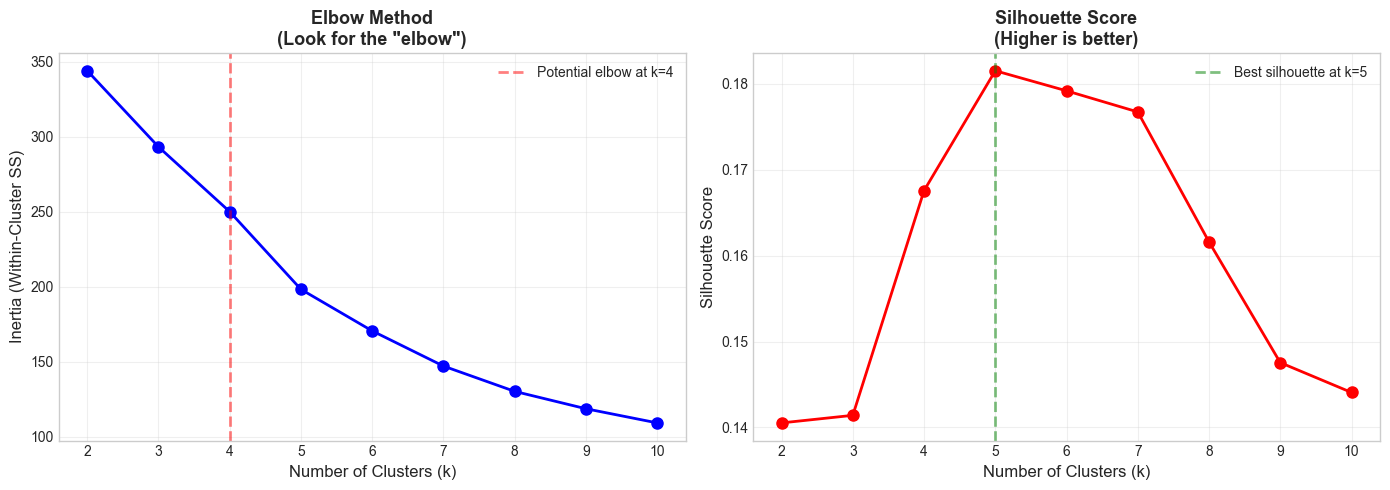


ANALYZING THE RESULTS

📊 ELBOW METHOD (Inertia):
   Detected elbow at: k=4
   Inertia at k=4: 250.12

   Interpretation:
   • Adding clusters before k=4: significant improvement
   • Adding clusters after k=4: diminishing returns

📈 SILHOUETTE METHOD (Cluster Quality):
   Best silhouette score at: k=5
   Silhouette score: 0.182
   Quality rating: Poor ❌

   Silhouette scores for common k values:
   • k=3: 0.141
   • k=4: 0.168
   • k=5: 0.182

DECISION ANALYSIS

🤔 Comparing methods:
   Elbow method suggests:     k=4
   Silhouette method suggests: k=5

✅ REASONABLE AGREEMENT: Methods suggest k=4 and k=5
   Recommending k=5 (better cluster quality)

📋 RECOMMENDATION SUMMARY:


,Metric,Value
0,Recommended k,5
1,Confidence Level,MEDIUM-HIGH
2,Reasoning,"Methods suggest similar values, choosing based..."
3,Inertia,198.34
4,Silhouette Score,0.182
5,Expected Quality,Poor ❌



💡 Practical Interpretation:
   k=5: Detailed segmentation
   • Nuanced categorization
   • Better for larger portfolios (50+ tokens)

🔬 Validation Note:
   Remember: We artificially created 3 distinct token groups
   Recommended k=5
   ⚠️  K-Means suggests 5 clusters (different from 3)
   → Algorithm may be detecting additional structure or noise

FINAL DECISION

🎯 We will use k=5 clusters for our analysis
   Confidence: MEDIUM-HIGH
   Silhouette score: 0.182

✍️  YOUR REFLECTION:

1. Do you agree with this recommendation? Why or why not?
   Your answer: _________________

2. What would happen if we used k=2 instead?
   Your answer: _________________

3. What would happen if we used k=8 instead?
   Your answer: _________________

4. Looking at the plots, where do YOU see the elbow?
   Your answer: _________________

✅ Elbow analysis complete! Optimal k=5

👉 Next: We'll fit K-Means with optimal k and analyze the clusters


In [8]:
print("=" * 70)
print("FINDING OPTIMAL NUMBER OF CLUSTERS - ELBOW METHOD")
print("=" * 70)

print("\n🎯 Goal: Determine the best value of k (number of clusters)")
print("   We'll test k from 2 to 10 and measure two metrics:")
print("   1. Inertia (within-cluster distance) - look for 'elbow'")
print("   2. Silhouette score (cluster separation) - look for peak")

print("\n⏱️  This will take about 10-20 seconds...")
print("   (We're running K-Means 9 times with different k values)\n")

# Create temporary K-Means object for testing
kmeans_temp = SimpleKMeans(n_clusters=3)  # Placeholder, we'll test multiple k

# Run elbow method
fig = kmeans_temp.plot_elbow(defi_data.values, max_k=10, figsize=(14, 5))
plt.show()

print("\n" + "=" * 70)
print("ANALYZING THE RESULTS")
print("=" * 70)

# Re-run the analysis to extract metrics for decision making
X_scaled = kmeans_temp.scaler.fit_transform(defi_data.values)

inertias = []
silhouettes = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, kmeans.labels_))

# Find the elbow using the "elbow detection" heuristic
# Calculate second derivative (rate of change of rate of change)
inertia_diffs = np.diff(inertias)
inertia_diffs2 = np.diff(inertia_diffs)
elbow_k = np.argmax(inertia_diffs2) + 2  # +2 due to double diff

# Find best silhouette
best_silhouette_idx = np.argmax(silhouettes)
best_silhouette_k = K_range[best_silhouette_idx]
best_silhouette_score = silhouettes[best_silhouette_idx]

print("\n📊 ELBOW METHOD (Inertia):")
print(f"   Detected elbow at: k={elbow_k}")
print(f"   Inertia at k={elbow_k}: {inertias[elbow_k-2]:.2f}")
print(f"\n   Interpretation:")
print(f"   • Adding clusters before k={elbow_k}: significant improvement")
print(f"   • Adding clusters after k={elbow_k}: diminishing returns")

print("\n📈 SILHOUETTE METHOD (Cluster Quality):")
print(f"   Best silhouette score at: k={best_silhouette_k}")
print(f"   Silhouette score: {best_silhouette_score:.3f}")

# Interpret silhouette score
if best_silhouette_score > 0.7:
    quality = "Excellent ⭐⭐⭐"
elif best_silhouette_score > 0.5:
    quality = "Good ⭐⭐"
elif best_silhouette_score > 0.25:
    quality = "Acceptable ⭐"
else:
    quality = "Poor ❌"

print(f"   Quality rating: {quality}")

# Show silhouette scores for key k values
print(f"\n   Silhouette scores for common k values:")
for k in [3, 4, 5]:
    if k <= 10:
        score = silhouettes[k-2]
        print(f"   • k={k}: {score:.3f}")

print("\n" + "=" * 70)
print("DECISION ANALYSIS")
print("=" * 70)

# Make recommendation
print(f"\n🤔 Comparing methods:")
print(f"   Elbow method suggests:     k={elbow_k}")
print(f"   Silhouette method suggests: k={best_silhouette_k}")

if elbow_k == best_silhouette_k:
    recommended_k = elbow_k
    confidence = "HIGH"
    reason = "Both methods agree"
    print(f"\n✅ STRONG AGREEMENT: Both methods suggest k={recommended_k}")
elif abs(elbow_k - best_silhouette_k) <= 1:
    recommended_k = best_silhouette_k  # Prefer silhouette if close
    confidence = "MEDIUM-HIGH"
    reason = "Methods suggest similar values, choosing based on silhouette"
    print(f"\n✅ REASONABLE AGREEMENT: Methods suggest k={elbow_k} and k={best_silhouette_k}")
    print(f"   Recommending k={recommended_k} (better cluster quality)")
else:
    # Check silhouette at elbow_k
    elbow_silhouette = silhouettes[elbow_k-2]
    if elbow_silhouette > 0.5:
        recommended_k = elbow_k
        confidence = "MEDIUM"
        reason = "Elbow point with acceptable silhouette score"
    else:
        recommended_k = best_silhouette_k
        confidence = "MEDIUM"
        reason = "Prioritizing cluster quality (silhouette)"
    print(f"\n⚠️  DISAGREEMENT: Elbow at k={elbow_k}, best silhouette at k={best_silhouette_k}")
    print(f"   Recommending k={recommended_k}")

# Additional validation
print(f"\n📋 RECOMMENDATION SUMMARY:")
print("=" * 70)

recommendation_table = pd.DataFrame({
    'Metric': ['Recommended k', 'Confidence Level', 'Reasoning', 
               'Inertia', 'Silhouette Score', 'Expected Quality'],
    'Value': [
        recommended_k,
        confidence,
        reason,
        f"{inertias[recommended_k-2]:.2f}",
        f"{silhouettes[recommended_k-2]:.3f}",
        quality if recommended_k == best_silhouette_k else "Good" if silhouettes[recommended_k-2] > 0.5 else "Acceptable"
    ]
})
display(recommendation_table)

print("\n💡 Practical Interpretation:")
if recommended_k == 3:
    print("   k=3: Simple segmentation (e.g., Low/Medium/High risk)")
    print("   • Easy to interpret and communicate")
    print("   • Good for basic portfolio diversification")
elif recommended_k == 4:
    print("   k=4: Balanced segmentation")
    print("   • Captures multiple dimensions (size + risk)")
    print("   • Most common choice for DeFi portfolios")
elif recommended_k == 5:
    print("   k=5: Detailed segmentation")
    print("   • Nuanced categorization")
    print("   • Better for larger portfolios (50+ tokens)")
else:
    print(f"   k={recommended_k}: Custom segmentation")
    print("   • Specific to your data structure")

# Compare with our artificial groups
print("\n🔬 Validation Note:")
print(f"   Remember: We artificially created 3 distinct token groups")
print(f"   Recommended k={recommended_k}")
if recommended_k == 3:
    print("   ✅ Perfect! K-Means detected our 3 groups!")
elif recommended_k == 4:
    print("   ⚠️  K-Means suggests 4 clusters (one more than we created)")
    print("   → Likely splitting one group or finding subtle patterns")
else:
    print(f"   ⚠️  K-Means suggests {recommended_k} clusters (different from 3)")
    print("   → Algorithm may be detecting additional structure or noise")

print("\n" + "=" * 70)
print("FINAL DECISION")
print("=" * 70)
print(f"\n🎯 We will use k={recommended_k} clusters for our analysis")
print(f"   Confidence: {confidence}")
print(f"   Silhouette score: {silhouettes[recommended_k-2]:.3f}")

# Store the decision
optimal_k = recommended_k

print("\n✍️  YOUR REFLECTION:")
print("=" * 70)
print("\n1. Do you agree with this recommendation? Why or why not?")
print("   Your answer: _________________")
print("\n2. What would happen if we used k=2 instead?")
print("   Your answer: _________________")
print("\n3. What would happen if we used k=8 instead?")
print("   Your answer: _________________")
print("\n4. Looking at the plots, where do YOU see the elbow?")
print("   Your answer: _________________")

print("\n" + "=" * 70)
print(f"✅ Elbow analysis complete! Optimal k={optimal_k}")
print("=" * 70)
print("\n👉 Next: We'll fit K-Means with optimal k and analyze the clusters")

---

## 🎯 Fitting K-Means and Interpreting Clusters

### What Happens Next?

Now that we've determined the optimal number of clusters (k), we'll:
1. **Fit K-Means** with our chosen k
2. **Assign each token** to a cluster
3. **Analyze cluster characteristics** (what makes each cluster unique?)
4. **Name the clusters** based on their profiles
5. **Validate** that clusters make economic sense

---

## 🔄 The K-Means Fitting Process

### Step-by-Step Breakdown
```
Input: 50 tokens × 8 features
       k = optimal number of clusters

Step 1: STANDARDIZATION
├─ Scale all features to mean=0, std=1
├─ Why? Prevent large values from dominating
└─ Result: Fair comparison across all features

Step 2: INITIALIZATION
├─ Randomly place k cluster centers
├─ Use k-means++ for smart initialization
└─ Result: Good starting positions

Step 3: ASSIGNMENT
├─ Calculate distance from each token to each center
├─ Assign token to nearest center
└─ Result: Each token belongs to one cluster

Step 4: UPDATE
├─ Move each center to mean of its assigned tokens
├─ Recalculate optimal center positions
└─ Result: Better cluster centers

Step 5: ITERATION
├─ Repeat steps 3-4 until convergence
├─ Convergence = centers stop moving
└─ Result: Final optimal clustering

Output: 50 tokens with cluster labels (0, 1, 2, ...)
```

---

## 📊 Understanding Cluster Assignments

### What the Labels Mean

After fitting, each token gets a **cluster label**:
```
TOKEN_1  → Cluster 0
TOKEN_2  → Cluster 2
TOKEN_3  → Cluster 1
TOKEN_4  → Cluster 0
...
```

**Important notes:**
- **Labels are arbitrary** (0, 1, 2, ... have no inherent meaning)
- **Order doesn't matter** (Cluster 0 isn't "better" than Cluster 1)
- **Labels can change** if you re-run K-Means with different random_state
- **Interpretation matters** (what makes each cluster unique?)

---

## 🔍 Analyzing Cluster Centroids

### What is a Centroid?

The **centroid** is the "center" or "average token" of each cluster.

**It's NOT a real token** - it's the mathematical average of all tokens in that cluster.

### Example Centroid Analysis
```
Cluster 0 Centroid:
  Mean_Return:      0.002  (0.2% daily)
  Volatility:       0.025  (2.5% daily)
  Volume_USD:       5.0M
  TVL_USD:          50M
  Market_Cap:       200M
  Liquidity_Score:  85
  ETH_Correlation:  0.75
  Sentiment_Score:  65

Interpretation: "High-cap stable tokens"
- Low volatility (2.5%)
- High liquidity (score 85)
- Large size (200M market cap)
- Strong ETH correlation (0.75)
```

---

## 🎨 Cluster Interpretation Strategy

### Step 1: Compare Centroids

Look at centroid values **relative to each other**:
```
                Cluster 0   Cluster 1   Cluster 2
Volatility:        2.5%        4.0%        8.0%  ← Cluster 2 is riskiest!
Market_Cap:        200M        80M         20M   ← Cluster 0 is largest!
Liquidity:         85          70          45    ← Cluster 0 most liquid!
```

### Step 2: Find Distinguishing Features

Which features **differ most** between clusters?

**High variance across clusters** = important distinguishing feature
**Low variance across clusters** = not useful for differentiation

### Step 3: Name Each Cluster

Give meaningful, descriptive names:

**Good names:**
- ✅ "Large-cap stable tokens"
- ✅ "Mid-cap growth tokens"
- ✅ "Small-cap high-risk tokens"
- ✅ "DeFi blue chips"

**Bad names:**
- ❌ "Cluster 0"
- ❌ "Group A"
- ❌ "The good ones"

---

## 📋 Cluster Profile Template

For each cluster, document:
```
CLUSTER 0: [Your Name Here]
─────────────────────────────
Size: 15 tokens (30% of portfolio)

Key Characteristics:
  • Volatility: LOW (2.5%)
  • Market Cap: HIGH ($200M avg)
  • Liquidity: HIGH (score 85)
  • Returns: MODERATE (0.2% daily)

Interpretation:
  Large, established protocols with stable performance.
  Lower risk, lower return profile. Good for conservative allocation.

Sample Tokens:
  TOKEN_1, TOKEN_5, TOKEN_8, ...

Portfolio Strategy:
  Allocate 40-50% of portfolio for stability and liquidity.
```

---

## 🎯 Common DeFi Cluster Patterns

### Pattern 1: Size-Based Clustering
```
Cluster 0: Large-cap (Uniswap, Aave, Compound)
Cluster 1: Mid-cap (newer established protocols)
Cluster 2: Small-cap (early-stage projects)
```

**Distinguishing features:** Market Cap, TVL, Volume, Liquidity

### Pattern 2: Risk-Based Clustering
```
Cluster 0: Conservative (low volatility, stable returns)
Cluster 1: Balanced (moderate volatility and returns)
Cluster 2: Aggressive (high volatility, high potential returns)
```

**Distinguishing features:** Volatility, Returns, Sentiment

### Pattern 3: Market Exposure Clustering
```
Cluster 0: ETH-correlated (follow Ethereum closely)
Cluster 1: Independent (move independently)
Cluster 2: Counter-cyclical (negative correlation)
```

**Distinguishing features:** ETH_Correlation, Sentiment, Returns

### Pattern 4: Hybrid Clustering (Most Common)
```
Cluster 0: Large stable (high cap, low vol)
Cluster 1: Small aggressive (low cap, high vol)
Cluster 2: Medium balanced (mid cap, mid vol)
Cluster 3: High-sentiment plays (driven by community)
```

**Distinguishing features:** Combination of size, risk, and sentiment

---

## 📈 Cluster Validation Checklist

After analyzing clusters, verify:

### ✅ Size Balance
- [ ] No cluster has > 70% of tokens
- [ ] No cluster has < 10% of tokens
- [ ] Relatively balanced distribution

### ✅ Clear Separation
- [ ] Centroids are clearly different
- [ ] Can identify 2-3 key distinguishing features per cluster
- [ ] Silhouette score > 0.25

### ✅ Economic Interpretability
- [ ] Each cluster has a meaningful name
- [ ] Clusters match known market categories
- [ ] Can explain clusters to non-technical stakeholders

### ✅ Actionable Insights
- [ ] Can use clusters for portfolio decisions
- [ ] Understand risk profile of each cluster
- [ ] Know which clusters to over/underweight

---

## 💡 Using Clusters for Portfolio Decisions

### Strategy 1: Equal Weight Across Clusters
```
Select 2 tokens from each cluster
→ Ensures diversification across all market segments
```

### Strategy 2: Risk-Adjusted Allocation
```
Conservative portfolio:
  • 50% from low-risk cluster
  • 30% from medium-risk cluster
  • 20% from high-risk cluster

Aggressive portfolio:
  • 20% from low-risk cluster
  • 30% from medium-risk cluster
  • 50% from high-risk cluster
```

### Strategy 3: Cluster Rotation
```
Bull market: Overweight high-risk cluster
Bear market: Overweight low-risk cluster
Sideways: Equal weight across all clusters
```

### Strategy 4: Within-Cluster Selection
```
For each cluster:
  1. Calculate Sharpe ratio (Return/Volatility)
  2. Select top 2 tokens by Sharpe ratio
  3. Ensures best risk-adjusted returns within each segment
```

---

## ⚠️ Common Interpretation Mistakes

### Mistake 1: Treating Labels as Rankings
❌ "Cluster 0 is better than Cluster 2"
✅ "Cluster 0 represents different characteristics than Cluster 2"

### Mistake 2: Ignoring Cluster Sizes
❌ "We have 4 equal clusters"
✅ "Cluster 0 has 25 tokens, Cluster 3 has only 5 tokens"

### Mistake 3: Over-interpreting Small Differences
❌ "Cluster 0 volatility: 2.5%, Cluster 1: 2.7% - totally different!"
✅ "Volatility is similar across these clusters; focus on other features"

### Mistake 4: Forcing Interpretations
❌ "This cluster MUST represent something specific"
✅ "This cluster captures residual variation; it's okay if interpretation is unclear"

---

## 🎓 What You'll Learn from the Next Cell

After running K-Means, you'll be able to:

1. **See cluster assignments** - which tokens belong to which cluster
2. **Compare centroid characteristics** - what makes each cluster unique
3. **Identify distinguishing features** - which features matter most
4. **Name the clusters** - give them meaningful interpretations
5. **Validate the results** - do they make economic sense?

---

## 📝 Questions to Answer After Fitting

**About the clusters:**
1. How many tokens in each cluster?
2. Are clusters balanced or imbalanced?
3. Which features differ most between clusters?

**About interpretation:**
4. What would you name each cluster?
5. Do the clusters match known DeFi categories?
6. Can you explain each cluster in one sentence?

**About portfolio decisions:**
7. Which cluster would you overweight/underweight?
8. How would you select tokens from each cluster?
9. What's your overall portfolio strategy using these clusters?

---

**👉 Run the next cell to fit K-Means with optimal k and analyze the clusters!**

FITTING K-MEANS WITH OPTIMAL k=5

🔧 Initializing K-Means with k=5 clusters...
   This will:
   1. Standardize all features
   2. Run K-Means algorithm (may take a few seconds)
   3. Assign each token to a cluster
   4. Calculate cluster centroids


✅ K-Means fitted successfully!
   Number of clusters: 5
   Inertia (within-cluster sum of squares): 198.34
   Lower inertia = tighter clusters

CLUSTER ASSIGNMENT COMPLETE

✅ All 50 tokens assigned to 5 clusters

📊 CLUSTER DISTRIBUTION:


,Cluster,Size,Percentage
0,0,26,52.0%
1,1,19,38.0%
2,2,1,2.0%
3,3,1,2.0%
4,4,3,6.0%


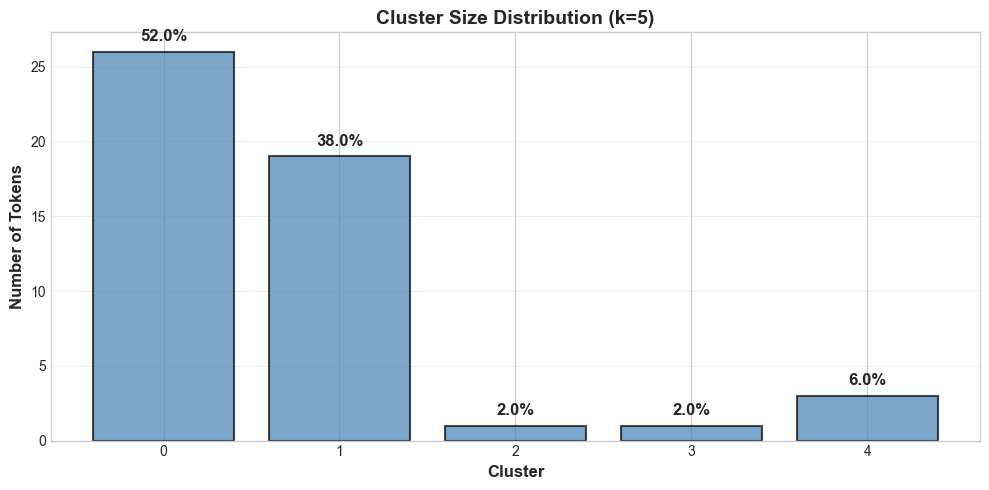


🔍 Balance Analysis:
   ⚠️  IMBALANCED: Largest cluster is 26.0x bigger than smallest
   → Consider adjusting k or checking for outliers

CLUSTER CHARACTERISTICS (CENTROIDS)

📋 Centroid Table:
   (Average feature values for each cluster)



,Mean_Return,Volatility,Volume_USD,TVL_USD,Market_Cap,Liquidity_Score,ETH_Correlation,Sentiment_Score
Cluster_0,0.0217,0.0280,1.331381e+07,1.439169e+08,2.793022e+08,78.8879,0.4238,48.9978
Cluster_1,-0.0693,0.0807,1.900170e+07,4.920246e+07,2.921135e+08,50.0026,0.5335,43.7827
Cluster_2,-0.0700,0.0173,7.535744e+08,9.403668e+07,7.517493e+06,29.2025,0.1030,48.6617
Cluster_3,0.0098,0.0781,1.215325e+07,5.363475e+10,4.553537e+08,92.7750,0.3183,48.2773
Cluster_4,-0.0420,0.0237,3.547835e+06,8.443985e+07,1.410193e+10,89.9992,0.6073,31.6785



💡 How to read this table:
   • Each row = a cluster's 'average token'
   • Each column = average value of that feature in the cluster
   • Compare rows to see what distinguishes clusters

IDENTIFYING DISTINGUISHING FEATURES

🎯 Most distinguishing features (high variance across clusters):
   These features differ the most between clusters:

   1. TVL_USD              (variation: 2.22)
      Range: 49202456.1995 to 53634748147.4533

   2. Volume_USD           (variation: 2.07)
      Range: 3547835.2370 to 753574417.1859

   3. Market_Cap           (variation: 2.05)
      Range: 7517492.5552 to 14101925559.7829

   4. Mean_Return          (variation: 1.45)
      Range: -0.0700 to 0.0217

   5. Volatility           (variation: 0.68)
      Range: 0.0173 to 0.0807

💡 These features are most useful for interpreting cluster differences!

DETAILED CLUSTER ANALYSIS

CLUSTER 0 - 26 tokens (52.0%)

📊 Average Characteristics:
   ⬇️ Mean_Return         :     0.0217 (LOW)
   ⬇️ Volatility          :

,Cluster,Size,Cap,Volatility,Liquidity,Your Name
0,0,26,Small,Low,High,_______________
1,1,19,Small,High,Low,_______________
2,2,1,Small,Low,Low,_______________
3,3,1,Small,High,High,_______________
4,4,3,Large,Low,High,_______________



💡 Naming suggestions:
   • Focus on 2-3 distinguishing characteristics
   • Use descriptive terms: Large/Mid/Small, Stable/Volatile, Liquid/Illiquid
   • Think about portfolio role: Conservative, Growth, Speculative
   • Examples: 'DeFi Blue Chips', 'High-Risk Growth', 'Stable Giants'

✅ Cluster analysis complete!

🎯 KEY TAKEAWAYS:
   • 50 tokens organized into 5 meaningful clusters
   • Each cluster has distinct risk/return characteristics
   • Clusters can guide portfolio construction and diversification

👉 Next: We'll visualize clusters in 2D space and build a sample portfolio


In [9]:
print("=" * 70)
print(f"FITTING K-MEANS WITH OPTIMAL k={optimal_k}")
print("=" * 70)

print(f"\n🔧 Initializing K-Means with k={optimal_k} clusters...")
print("   This will:")
print("   1. Standardize all features")
print("   2. Run K-Means algorithm (may take a few seconds)")
print("   3. Assign each token to a cluster")
print("   4. Calculate cluster centroids\n")

# Initialize K-Means with optimal k
kmeans_model = SimpleKMeans(n_clusters=optimal_k, random_state=42)

# Fit K-Means and get cluster assignments
clusters = kmeans_model.fit_predict(
    defi_data.values,
    feature_names=defi_data.columns.tolist()
)

print("\n" + "=" * 70)
print("CLUSTER ASSIGNMENT COMPLETE")
print("=" * 70)

# Add cluster labels to our data
defi_data_clustered = defi_data.copy()
defi_data_clustered['Cluster'] = clusters

print(f"\n✅ All {len(defi_data)} tokens assigned to {optimal_k} clusters")

# Get cluster summary
cluster_summary = kmeans_model.get_cluster_summary(defi_data.values)

print("\n📊 CLUSTER DISTRIBUTION:")
print("=" * 70)
display(cluster_summary)

# Visualize distribution
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(cluster_summary['Cluster'], cluster_summary['Size'], 
              alpha=0.7, color='steelblue', edgecolor='black', linewidth=1.5)

# Add percentage labels on bars
for i, (idx, row) in enumerate(cluster_summary.iterrows()):
    ax.text(row['Cluster'], row['Size'] + 0.5, row['Percentage'], 
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Tokens', fontsize=12, fontweight='bold')
ax.set_title(f'Cluster Size Distribution (k={optimal_k})', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticks(cluster_summary['Cluster'])

plt.tight_layout()
plt.show()

# Check for imbalanced clusters
print("\n🔍 Balance Analysis:")
max_size = cluster_summary['Size'].max()
min_size = cluster_summary['Size'].min()
size_ratio = max_size / min_size

if size_ratio > 5:
    print(f"   ⚠️  IMBALANCED: Largest cluster is {size_ratio:.1f}x bigger than smallest")
    print(f"   → Consider adjusting k or checking for outliers")
elif size_ratio > 2.5:
    print(f"   ⚠️  SOMEWHAT IMBALANCED: Size ratio is {size_ratio:.1f}x")
    print(f"   → Acceptable, but one cluster dominates")
else:
    print(f"   ✅ WELL BALANCED: Size ratio is {size_ratio:.1f}x")
    print(f"   → Good distribution across clusters")

print("\n" + "=" * 70)
print("CLUSTER CHARACTERISTICS (CENTROIDS)")
print("=" * 70)

# Get cluster centroids (average values)
centroids = kmeans_model.get_cluster_centers()

print("\n📋 Centroid Table:")
print("   (Average feature values for each cluster)")
print()
display(centroids.round(4))

print("\n💡 How to read this table:")
print("   • Each row = a cluster's 'average token'")
print("   • Each column = average value of that feature in the cluster")
print("   • Compare rows to see what distinguishes clusters")

# Analyze feature variance across clusters
print("\n" + "=" * 70)
print("IDENTIFYING DISTINGUISHING FEATURES")
print("=" * 70)

# Calculate coefficient of variation (std/mean) for each feature across clusters
feature_cv = centroids.std() / (centroids.mean().abs() + 1e-10)  # Avoid division by zero
distinguishing_features = feature_cv.sort_values(ascending=False)

print("\n🎯 Most distinguishing features (high variance across clusters):")
print("   These features differ the most between clusters:\n")

for i, (feature, cv) in enumerate(distinguishing_features.head(5).items(), 1):
    print(f"   {i}. {feature:20s} (variation: {cv:.2f})")
    
    # Show range across clusters
    min_val = centroids[feature].min()
    max_val = centroids[feature].max()
    print(f"      Range: {min_val:.4f} to {max_val:.4f}")
    print()

print("💡 These features are most useful for interpreting cluster differences!")

print("\n" + "=" * 70)
print("DETAILED CLUSTER ANALYSIS")
print("=" * 70)

# Analyze each cluster in detail
for i in range(optimal_k):
    cluster_data = defi_data_clustered[defi_data_clustered['Cluster'] == i]
    cluster_size = len(cluster_data)
    
    print(f"\n{'='*70}")
    print(f"CLUSTER {i} - {cluster_size} tokens ({cluster_size/len(defi_data)*100:.1f}%)")
    print('='*70)
    
    # Calculate statistics
    cluster_features = cluster_data.drop('Cluster', axis=1)
    avg = cluster_features.mean()
    std = cluster_features.std()
    
    print("\n📊 Average Characteristics:")
    for feature in defi_data.columns:
        # Compare to overall average
        overall_avg = defi_data[feature].mean()
        diff_pct = ((avg[feature] - overall_avg) / overall_avg * 100) if overall_avg != 0 else 0
        
        # Determine if HIGH, LOW, or AVERAGE
        if abs(diff_pct) < 20:
            level = "AVERAGE"
            emoji = "➡️"
        elif diff_pct > 0:
            level = "HIGH" if diff_pct > 50 else "ABOVE AVG"
            emoji = "⬆️"
        else:
            level = "LOW" if diff_pct < -50 else "BELOW AVG"
            emoji = "⬇️"
        
        print(f"   {emoji} {feature:20s}: {avg[feature]:>10.4f} ({level})")
    
    # Suggest interpretation based on patterns
    print("\n💭 Interpretation:")
    
    # Check key patterns
    high_volatility = avg['Volatility'] > defi_data['Volatility'].mean() * 1.3
    low_volatility = avg['Volatility'] < defi_data['Volatility'].mean() * 0.7
    high_marketcap = avg['Market_Cap'] > defi_data['Market_Cap'].mean() * 1.3
    low_marketcap = avg['Market_Cap'] < defi_data['Market_Cap'].mean() * 0.7
    high_liquidity = avg['Liquidity_Score'] > defi_data['Liquidity_Score'].mean() * 1.2
    
    interpretations = []
    
    if high_marketcap and high_liquidity and low_volatility:
        interpretations.append("🏛️ LARGE-CAP STABLE: Established, liquid, low-risk tokens")
    elif low_marketcap and high_volatility:
        interpretations.append("🚀 SMALL-CAP HIGH-RISK: High potential, high volatility")
    elif not high_marketcap and not low_marketcap and not high_volatility:
        interpretations.append("⚖️ MID-CAP BALANCED: Moderate size and risk profile")
    
    if avg['ETH_Correlation'] > 0.7:
        interpretations.append("📊 HIGH ETH CORRELATION: Follows Ethereum closely")
    elif avg['ETH_Correlation'] < 0.3:
        interpretations.append("🔄 LOW ETH CORRELATION: Independent price movement")
    
    if avg['Mean_Return'] > defi_data['Mean_Return'].mean() * 1.5:
        interpretations.append("📈 HIGH RETURNS: Outperforming average")
    
    if interpretations:
        for interp in interpretations:
            print(f"   • {interp}")
    else:
        print("   • MIXED PROFILE: Combination of various characteristics")
    
    # Show sample tokens
    print(f"\n📋 Sample Tokens (first 8):")
    sample_tokens = cluster_data.index[:8].tolist()
    print(f"   {', '.join(sample_tokens)}")
    if len(cluster_data) > 8:
        print(f"   ... and {len(cluster_data) - 8} more")

print("\n" + "=" * 70)
print("CLUSTER NAMING EXERCISE")
print("=" * 70)

print("\n✍️ Based on the analysis above, suggest names for each cluster:")
print()

# Create summary table for naming
naming_summary = []
for i in range(optimal_k):
    cluster_data = defi_data_clustered[defi_data_clustered['Cluster'] == i]
    cluster_features = cluster_data.drop('Cluster', axis=1)
    avg = cluster_features.mean()
    
    # Create a quick profile
    vol_level = "High" if avg['Volatility'] > defi_data['Volatility'].mean() * 1.2 else "Low" if avg['Volatility'] < defi_data['Volatility'].mean() * 0.8 else "Med"
    cap_level = "Large" if avg['Market_Cap'] > defi_data['Market_Cap'].mean() * 1.2 else "Small" if avg['Market_Cap'] < defi_data['Market_Cap'].mean() * 0.8 else "Mid"
    liq_level = "High" if avg['Liquidity_Score'] > defi_data['Liquidity_Score'].mean() * 1.1 else "Low"
    
    naming_summary.append({
        'Cluster': i,
        'Size': len(cluster_data),
        'Cap': cap_level,
        'Volatility': vol_level,
        'Liquidity': liq_level,
        'Your Name': '_______________'
    })

naming_df = pd.DataFrame(naming_summary)
display(naming_df)

print("\n💡 Naming suggestions:")
print("   • Focus on 2-3 distinguishing characteristics")
print("   • Use descriptive terms: Large/Mid/Small, Stable/Volatile, Liquid/Illiquid")
print("   • Think about portfolio role: Conservative, Growth, Speculative")
print("   • Examples: 'DeFi Blue Chips', 'High-Risk Growth', 'Stable Giants'")

print("\n" + "=" * 70)
print("✅ Cluster analysis complete!")
print("=" * 70)

print("\n🎯 KEY TAKEAWAYS:")
print(f"   • {len(defi_data)} tokens organized into {optimal_k} meaningful clusters")
print("   • Each cluster has distinct risk/return characteristics")
print("   • Clusters can guide portfolio construction and diversification")

print("\n👉 Next: We'll visualize clusters in 2D space and build a sample portfolio")

---

## 📊 Visualizing Clusters in 2D Space

### The Visualization Challenge

We have a **problem**: Our tokens exist in **8-dimensional space** (8 features), but:
- Humans can only visualize **2D or 3D**
- We need to see clusters to validate they make sense
- We want to show cluster separation visually

**Solution:** Use **dimensionality reduction** to project into 2D!

---

## 🎨 Why Visualize Clusters?

### Visual validation helps us:

**1. Verify Cluster Separation**
```
Good clustering:           Bad clustering:
  ●●●        ●●●              ●●●●●●●●●
  ●●●        ●●●              ●●●●●●●●●
               ●●●            ●●●●●●●●●
  ●●●        ●●●              (all mixed)
Clear groups!             
```

**2. Identify Outliers**
- Tokens far from any cluster center
- May be unique opportunities or data errors

**3. Detect Overlaps**
- Where clusters blend together
- May indicate we need different k

**4. Communicate Results**
- Show stakeholders cluster structure
- Easier than explaining 8D centroids!

**5. Build Intuition**
- See which tokens are similar
- Understand cluster boundaries

---

## 🔧 Method: PCA for 2D Projection

### Why PCA?

We already learned PCA reduces dimensions while keeping information. Perfect for visualization!

**Process:**
```
8D Data (original features)
    ↓
  PCA (keep 2 components)
    ↓
2D Data (PC1 and PC2)
    ↓
Plot with cluster colors
```

**What we're plotting:**
- **X-axis:** PC1 (usually "size" factor)
- **Y-axis:** PC2 (usually "risk" factor)
- **Colors:** Different color per cluster
- **Points:** Each token

---

## 📐 Understanding the 2D Plot

### Components of the Visualization

**1. Axes**
```
      PC2 (Risk Factor)
       ↑
       |   ● Cluster 0
       |       ● Cluster 1
       |   ●       ●
       |       ● ●
       |   ●   ●
       |● ●     ● Cluster 2
       |────────────────→ PC1 (Size Factor)
```

**2. Point Colors**
- Each cluster gets a distinct color
- Same-color points belong to same cluster
- Helps visualize group membership

**3. Point Positions**
- **Top-right:** High PC1, High PC2 (large & risky)
- **Top-left:** Low PC1, High PC2 (small & risky)
- **Bottom-right:** High PC1, Low PC2 (large & stable)
- **Bottom-left:** Low PC1, Low PC2 (small & stable)

**4. Cluster Boundaries**
- Natural groupings visible
- Some overlap is normal
- Clear separation = good clustering

---

## 🎯 What Makes a Good Cluster Visualization?

### ✅ Indicators of Good Clustering

**1. Visual Separation**
```
✅ Good: Clear space between cluster groups
   ●●●        ●●●        ●●●
   ●●●        ●●●        ●●●
   
❌ Bad: Clusters completely overlap
   ●●●●●●●●●●●●●
   ●●●●●●●●●●●●●
```

**2. Reasonable Compactness**
```
✅ Good: Points cluster around centers
   ●●●
   ●●●  (tight group)
   ●●●
   
❌ Bad: Points spread everywhere
   ●
      ●    ●
         ●     ●
   ●        ●
```

**3. Balanced Distribution**
```
✅ Good: Clusters have similar densities
   ●●●  ●●●  ●●●
   ●●●  ●●●  ●●●
   
❌ Bad: One huge cluster, others tiny
   ●●●●●●●●●
   ●●●●●●●●●  ●  ●
```

**4. Few Outliers**
```
✅ Good: Most points clearly belong
   ●●●
   ●●●  ●●●
        ●●●
   
⚠️ Concerning: Many points between clusters
   ●●●
   ●●● ● ● ●●●
       ● ●  ●●●
```

---

## 📊 Common Visualization Patterns

### Pattern 1: Well-Separated Clusters
```
Plot appearance:
   |
   |  ●●● (Cluster 0)
   |
   |          ●●● (Cluster 1)
   |
   |    ●●● (Cluster 2)
   |─────────────────
   
Interpretation:
- Clusters are clearly distinct
- K-Means worked well
- High confidence in assignments
```

### Pattern 2: Partial Overlap
```
Plot appearance:
   |
   |  ●●●●●● (Cluster 0 & 1 overlap)
   |    ●●●
   |
   |         ●●● (Cluster 2 separate)
   |─────────────────
   
Interpretation:
- Some clusters blend together
- May share characteristics
- Consider merging overlapping clusters
```

### Pattern 3: One Dominant Cluster
```
Plot appearance:
   |
   |  ●●●●●●●●●●●●●
   |  ●●●●●●●●●●●●●  ● ●
   |  ●●●●●●●●●●●●●
   |─────────────────
   
Interpretation:
- One cluster dominates
- Others are outliers/niche groups
- May need different k
```

### Pattern 4: Linear Separation
```
Plot appearance:
   |
   |  ●●●  ●●●  ●●●
   |  ●●●  ●●●  ●●●
   |  ●●●  ●●●  ●●●
   |─────────────────
   
Interpretation:
- Clusters align along PC1
- Main differentiator is size/liquidity
- Risk (PC2) less important
```

---

## 🔍 How to Interpret Your Plot

### Step 1: Overall Structure

**Ask yourself:**
1. Can I visually identify the clusters?
2. Are they reasonably separated?
3. How much do they overlap?

### Step 2: Cluster Positions

**Quadrant analysis:**
```
      High Risk (PC2)
           ↑
  Small+   |   Large+
  Risky    |   Risky
           |
←──────────┼──────────→ Size (PC1)
           |
  Small+   |   Large+
  Safe     |   Safe
           ↓
       Low Risk
```

**Interpret based on position:**
- **Top-right:** Large risky tokens (growth opportunities?)
- **Top-left:** Small risky tokens (speculative plays?)
- **Bottom-right:** Large stable tokens (blue chips?)
- **Bottom-left:** Small stable tokens (overlooked gems?)

### Step 3: Token Positions

**Look for:**
- Tokens on cluster edges (borderline cases)
- Tokens between clusters (hard to categorize)
- Outlier tokens (very different from others)

### Step 4: Validate Against Centroids

**Cross-check:**
- Do visual clusters match centroid analysis?
- Are distinguishing features visible in plot?
- Does positioning make economic sense?

---

## ⚠️ Important Caveats

### 1. Information Loss

**Remember:** 2D plot only shows PC1 and PC2
- Usually captures 50-70% of variance
- Other PCs (PC3, PC4, ...) are hidden
- Some cluster separation may be in higher dimensions

**Example:**
```
2D view: Clusters overlap
3D view: Actually well-separated in PC3 dimension
```

### 2. PCA Limitations

- PCA projects based on variance, not cluster structure
- Best 2D view might not show all cluster separation
- Alternative: Use t-SNE or UMAP for better visualization

### 3. Projection Artifacts

- Distance in 2D ≠ distance in 8D
- Some nearby points in 2D may be far in 8D
- Some far points in 2D may be close in 8D

---

## 💡 Reading the Plot Like a Pro

### For Portfolio Managers:

**Question 1: "Where should I focus?"**
- Look at cluster centers
- Identify which quadrant aligns with strategy

**Question 2: "How diverse is my portfolio?"**
- Points spread across all quadrants = diverse
- Points clustered in one area = concentrated risk

**Question 3: "Are there outliers?"**
- Isolated points = unique risk/return profiles
- Could be opportunities or red flags

**Question 4: "Which tokens are similar?"**
- Close points in same cluster = substitutes
- Can swap one for another without changing profile

---

## 🎓 What You'll Learn from the Next Cell

After viewing the 2D visualization, you'll be able to:

1. **Visually confirm** cluster separation
2. **Identify outliers** and edge cases
3. **Understand spatial relationships** between tokens
4. **Validate** K-Means results visually
5. **Communicate** cluster structure to others

---

## 📝 Questions to Answer After Visualization

**About separation:**
1. Are clusters well-separated or overlapping?
2. Do any clusters blend together?
3. Are there clear boundaries?

**About structure:**
4. Which quadrants are most/least populated?
5. Where are cluster centers located?
6. Is the distribution symmetric or skewed?

**About tokens:**
7. Which tokens are outliers?
8. Which tokens are on cluster boundaries?
9. Do similar tokens cluster together?

**About validation:**
10. Does the visualization match your expectations?
11. Do clusters make economic sense spatially?
12. Would you adjust k based on what you see?

---

**👉 Run the next cell to create the 2D cluster visualization!**

We'll use PCA to reduce from 8D to 2D, then plot all tokens colored by cluster.

VISUALIZING CLUSTERS IN 2D SPACE

📊 Challenge: Our tokens exist in 8-dimensional space
   Solution: Use PCA to project into 2D for visualization

🔧 Process:
   1. Apply PCA to reduce 8 features → 2 principal components
   2. Plot tokens using PC1 (x-axis) and PC2 (y-axis)
   3. Color each token by its cluster assignment
   4. Analyze the visual pattern

Step 1: Applying PCA for 2D projection...

✅ PCA fitted successfully!
   Components: 2
   Total variance explained: 38.94%
   ✅ PCA complete!
   • PC1 explains: 22.4% of variance
   • PC2 explains: 16.6% of variance
   • Total captured in 2D: 38.9%

   ⚠️  Warning: Only 38.9% of variance shown in 2D
      Much cluster separation may be in higher dimensions

📊 Understanding the axes:

PC1 (X-axis) top loadings:
   • Liquidity_Score: +0.518
   • Volatility: -0.487
   • Market_Cap: +0.393

PC2 (Y-axis) top loadings:
   • Mean_Return: +0.466
   • ETH_Correlation: -0.443
   • TVL_USD: +0.421

Step 2: Creating visualization...


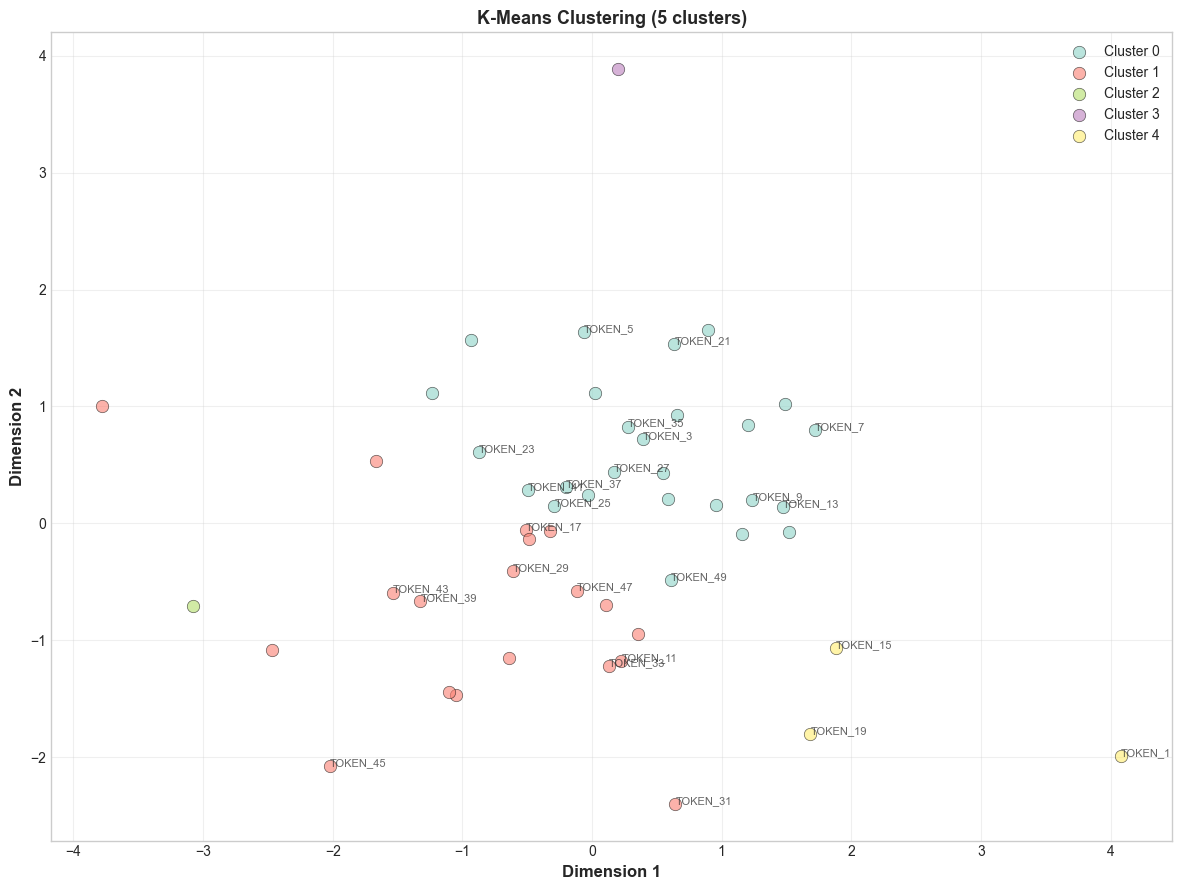


INTERPRETING THE VISUALIZATION

🔍 Cluster Analysis in 2D Space:

Cluster 0:
   Center: PC1=+0.44, PC2=+0.63
   Spread: PC1±0.79, PC2±0.57

Cluster 1:
   Center: PC1=-0.85, PC2=-0.77
   Spread: PC1±1.07, PC2±0.81

Cluster 2:
   Center: PC1=-3.08, PC2=-0.70
   Spread: PC1±0.00, PC2±0.00
   Position: Low PC1 (size)

Cluster 3:
   Center: PC1=+0.20, PC2=+3.89
   Spread: PC1±0.00, PC2±0.00
   Position: High PC2 (risk)

Cluster 4:
   Center: PC1=+2.55, PC2=-1.62
   Spread: PC1±1.09, PC2±0.40
   Position: High PC1 (size), Low PC2 (risk)

📏 Cluster Separation (distance between centers):
   Larger distance = better separation

   Cluster 0 ↔ Cluster 1: 1.90
   Cluster 0 ↔ Cluster 2: 3.76
   Cluster 0 ↔ Cluster 3: 3.27
   Cluster 0 ↔ Cluster 4: 3.08
   Cluster 1 ↔ Cluster 2: 2.23
   Cluster 1 ↔ Cluster 3: 4.77
   Cluster 1 ↔ Cluster 4: 3.50
   Cluster 2 ↔ Cluster 3: 5.64
   Cluster 2 ↔ Cluster 4: 5.70
   Cluster 3 ↔ Cluster 4: 5.99

   Average separation: 3.98
   ✅ Excellent separation - cluste

,Token,Cluster,Distance
0,TOKEN_40,1,3.423501



💡 What to do with outliers:
   • Investigate: Check if data is correct
   • Analyze: Understand what makes them unique
   • Decide: Include/exclude based on investment strategy

QUADRANT ANALYSIS

📍 Analyzing token distribution across quadrants:
   (Based on PC1 and PC2 coordinates)

   High PC1, High PC2  : 16 tokens ( 32.0%)
   Low PC1, High PC2   : 10 tokens ( 20.0%)
   Low PC1, Low PC2    : 13 tokens ( 26.0%)
   High PC1, Low PC2   : 11 tokens ( 22.0%)

💡 Quadrant interpretation (typical):
   • High PC1, High PC2:  Large & Risky tokens
   • Low PC1, High PC2:   Small & Risky tokens
   • Low PC1, Low PC2:    Small & Stable tokens
   • High PC1, Low PC2:   Large & Stable tokens

VISUAL VALIDATION SUMMARY

✅ Checklist - Does the visualization show:
   ✅ Clear cluster separation
   ⚠️  Reasonably balanced cluster sizes
   ⚠️  Sufficient variance captured in 2D
   ✅ Reasonable number of outliers

⚠️  OVERALL: Clustering is ACCEPTABLE but has some issues
   Consider adjusting k or inves

In [10]:
print("=" * 70)
print("VISUALIZING CLUSTERS IN 2D SPACE")
print("=" * 70)

print("\n📊 Challenge: Our tokens exist in 8-dimensional space")
print("   Solution: Use PCA to project into 2D for visualization")
print("\n🔧 Process:")
print("   1. Apply PCA to reduce 8 features → 2 principal components")
print("   2. Plot tokens using PC1 (x-axis) and PC2 (y-axis)")
print("   3. Color each token by its cluster assignment")
print("   4. Analyze the visual pattern\n")

# Apply PCA to reduce to 2D
print("Step 1: Applying PCA for 2D projection...")
pca_2d = SimplePCA(n_components=2)
X_2d = pca_2d.fit_transform(defi_data.values, feature_names=defi_data.columns.tolist())

# Get variance explained by PC1 and PC2
var_pc1 = pca_2d.pca.explained_variance_ratio_[0]
var_pc2 = pca_2d.pca.explained_variance_ratio_[1]
total_var_2d = var_pc1 + var_pc2

print(f"   ✅ PCA complete!")
print(f"   • PC1 explains: {var_pc1:.1%} of variance")
print(f"   • PC2 explains: {var_pc2:.1%} of variance")
print(f"   • Total captured in 2D: {total_var_2d:.1%}")

if total_var_2d < 0.50:
    print(f"\n   ⚠️  Warning: Only {total_var_2d:.1%} of variance shown in 2D")
    print(f"      Much cluster separation may be in higher dimensions")
elif total_var_2d < 0.70:
    print(f"\n   ✅ Good: {total_var_2d:.1%} of variance visible in 2D")
else:
    print(f"\n   ✅ Excellent: {total_var_2d:.1%} of variance captured in 2D")

# Show what PC1 and PC2 represent
print("\n📊 Understanding the axes:")
loadings_2d = pca_2d.get_loadings()

print("\nPC1 (X-axis) top loadings:")
pc1_top = loadings_2d['PC1'].abs().nlargest(3)
for feature in pc1_top.index:
    loading = loadings_2d.loc[feature, 'PC1']
    print(f"   • {feature}: {loading:+.3f}")

print("\nPC2 (Y-axis) top loadings:")
pc2_top = loadings_2d['PC2'].abs().nlargest(3)
for feature in pc2_top.index:
    loading = loadings_2d.loc[feature, 'PC2']
    print(f"   • {feature}: {loading:+.3f}")

print("\n" + "=" * 70)
print("Step 2: Creating visualization...")
print("=" * 70)

# Create the plot
fig = kmeans_model.plot_clusters_2d(
    X_2d,
    labels=defi_data.index.tolist(),
    figsize=(12, 9)
)
plt.show()

print("\n" + "=" * 70)
print("INTERPRETING THE VISUALIZATION")
print("=" * 70)

# Analyze cluster separation in 2D
clusters = kmeans_model.kmeans.labels_

print("\n🔍 Cluster Analysis in 2D Space:")

# Calculate cluster statistics in 2D
for i in range(optimal_k):
    mask = clusters == i
    cluster_points = X_2d[mask]
    
    # Center of cluster in 2D
    center_pc1 = cluster_points[:, 0].mean()
    center_pc2 = cluster_points[:, 1].mean()
    
    # Spread of cluster
    std_pc1 = cluster_points[:, 0].std()
    std_pc2 = cluster_points[:, 1].std()
    
    print(f"\nCluster {i}:")
    print(f"   Center: PC1={center_pc1:+.2f}, PC2={center_pc2:+.2f}")
    print(f"   Spread: PC1±{std_pc1:.2f}, PC2±{std_pc2:.2f}")
    
    # Interpret position
    position_desc = []
    if abs(center_pc1) > 1.0:
        position_desc.append(f"{'High' if center_pc1 > 0 else 'Low'} PC1 (size)")
    if abs(center_pc2) > 1.0:
        position_desc.append(f"{'High' if center_pc2 > 0 else 'Low'} PC2 (risk)")
    
    if position_desc:
        print(f"   Position: {', '.join(position_desc)}")

# Calculate pairwise cluster distances
print("\n📏 Cluster Separation (distance between centers):")
print("   Larger distance = better separation\n")

from scipy.spatial.distance import pdist, squareform

# Get cluster centers in 2D
cluster_centers_2d = []
for i in range(optimal_k):
    mask = clusters == i
    center = X_2d[mask].mean(axis=0)
    cluster_centers_2d.append(center)

cluster_centers_2d = np.array(cluster_centers_2d)
distances = squareform(pdist(cluster_centers_2d, metric='euclidean'))

for i in range(optimal_k):
    for j in range(i+1, optimal_k):
        dist = distances[i, j]
        print(f"   Cluster {i} ↔ Cluster {j}: {dist:.2f}")

avg_separation = distances[np.triu_indices_from(distances, k=1)].mean()
print(f"\n   Average separation: {avg_separation:.2f}")

if avg_separation > 3.0:
    print("   ✅ Excellent separation - clusters are well-defined")
elif avg_separation > 2.0:
    print("   ✅ Good separation - clusters are reasonably distinct")
elif avg_separation > 1.0:
    print("   ⚠️  Moderate separation - some overlap expected")
else:
    print("   ⚠️  Poor separation - clusters may be overlapping significantly")

# Identify outliers (tokens far from their cluster center)
print("\n" + "=" * 70)
print("IDENTIFYING OUTLIERS")
print("=" * 70)

print("\n🎯 Outliers are tokens far from their cluster center")
print("   They may represent:")
print("   • Unique investment opportunities")
print("   • Data anomalies")
print("   • Tokens that don't fit any category well\n")

outliers_found = []

for i in range(optimal_k):
    mask = clusters == i
    cluster_points = X_2d[mask]
    cluster_tokens = defi_data.index[mask]
    
    # Calculate distance from each point to cluster center
    center = cluster_points.mean(axis=0)
    distances_from_center = np.sqrt(((cluster_points - center)**2).sum(axis=1))
    
    # Outliers are > 2.5 standard deviations from center
    threshold = distances_from_center.mean() + 2.5 * distances_from_center.std()
    outlier_mask = distances_from_center > threshold
    
    if outlier_mask.any():
        outlier_indices = np.where(outlier_mask)[0]
        for idx in outlier_indices:
            token_name = cluster_tokens[idx]
            distance = distances_from_center[idx]
            outliers_found.append({
                'Token': token_name,
                'Cluster': i,
                'Distance': distance
            })

if outliers_found:
    outliers_df = pd.DataFrame(outliers_found).sort_values('Distance', ascending=False)
    print(f"Found {len(outliers_df)} potential outliers:\n")
    display(outliers_df.head(10))
    
    print("\n💡 What to do with outliers:")
    print("   • Investigate: Check if data is correct")
    print("   • Analyze: Understand what makes them unique")
    print("   • Decide: Include/exclude based on investment strategy")
else:
    print("✅ No significant outliers detected")
    print("   All tokens fit reasonably well into their clusters")

print("\n" + "=" * 70)
print("QUADRANT ANALYSIS")
print("=" * 70)

print("\n📍 Analyzing token distribution across quadrants:")
print("   (Based on PC1 and PC2 coordinates)\n")

# Define quadrants
quadrants = {
    'High PC1, High PC2': (X_2d[:, 0] > 0) & (X_2d[:, 1] > 0),
    'Low PC1, High PC2': (X_2d[:, 0] < 0) & (X_2d[:, 1] > 0),
    'Low PC1, Low PC2': (X_2d[:, 0] < 0) & (X_2d[:, 1] < 0),
    'High PC1, Low PC2': (X_2d[:, 0] > 0) & (X_2d[:, 1] < 0)
}

for quadrant_name, quadrant_mask in quadrants.items():
    count = quadrant_mask.sum()
    percentage = count / len(defi_data) * 100
    print(f"   {quadrant_name:20s}: {count:2d} tokens ({percentage:5.1f}%)")

print("\n💡 Quadrant interpretation (typical):")
print("   • High PC1, High PC2:  Large & Risky tokens")
print("   • Low PC1, High PC2:   Small & Risky tokens")  
print("   • Low PC1, Low PC2:    Small & Stable tokens")
print("   • High PC1, Low PC2:   Large & Stable tokens")

print("\n" + "=" * 70)
print("VISUAL VALIDATION SUMMARY")
print("=" * 70)

print("\n✅ Checklist - Does the visualization show:")

# Check 1: Separation
separation_ok = avg_separation > 1.5
print(f"   {'✅' if separation_ok else '❌'} Clear cluster separation")

# Check 2: Balance
size_variance = cluster_summary['Size'].std()
balance_ok = size_variance < len(defi_data) * 0.2
print(f"   {'✅' if balance_ok else '⚠️ '} Reasonably balanced cluster sizes")

# Check 3: Coverage
coverage_ok = total_var_2d > 0.5
print(f"   {'✅' if coverage_ok else '⚠️ '} Sufficient variance captured in 2D")

# Check 4: Outliers
outliers_ok = len(outliers_found) < len(defi_data) * 0.1  # Less than 10% outliers
print(f"   {'✅' if outliers_ok else '⚠️ '} Reasonable number of outliers")

# Overall assessment
all_ok = separation_ok and balance_ok and coverage_ok and outliers_ok

print(f"\n{'='*70}")
if all_ok:
    print("✅ OVERALL: Clustering looks GOOD!")
    print("   Clusters are well-defined and make visual sense")
else:
    print("⚠️  OVERALL: Clustering is ACCEPTABLE but has some issues")
    print("   Consider adjusting k or investigating outliers")

print("\n✍️  YOUR INTERPRETATION:")
print("=" * 70)

print("\n1. Are the clusters visually well-separated?")
print("   Your answer: _________________")

print("\n2. Which clusters overlap the most?")
print("   Your answer: _________________")

print("\n3. Based on the plot, do the cluster assignments make sense?")
print("   Your answer: _________________")

print("\n4. Would you adjust k based on this visualization? Why?")
print("   Your answer: _________________")

print("\n5. Which quadrant represents the 'safest' tokens?")
print("   Your answer: _________________")

print("\n" + "=" * 70)
print("✅ 2D visualization complete!")
print("=" * 70)

print("\n👉 Next: We'll use these clusters to build a diversified portfolio")

---

## 💼 Portfolio Construction Using Clusters

### From Analysis to Action

We've done the hard work:
- ✅ Applied PCA to understand variance structure
- ✅ Found optimal number of clusters with elbow method
- ✅ Fitted K-Means and interpreted cluster characteristics
- ✅ Visualized clusters in 2D space

**Now the exciting part:** Use these insights to build an actual portfolio!

---

## 🎯 Why Cluster-Based Portfolio Construction?

### Traditional Approach (Problems)
```
❌ Manual selection:
   • Subjective decisions
   • Unconscious bias toward familiar tokens
   • May miss diversification opportunities
   • Hard to justify choices

❌ Random selection:
   • No strategy
   • Likely concentrated risk
   • Difficult to rebalance
```

### Cluster-Based Approach (Benefits)
```
✅ Systematic diversification:
   • Select from each cluster
   • Ensures exposure to different market segments
   • Reduces concentration risk

✅ Risk management:
   • Understand portfolio risk profile
   • Adjust allocation by cluster
   • Balance risk/return systematically

✅ Transparent methodology:
   • Clear selection criteria
   • Easy to explain to stakeholders
   • Reproducible and auditable
```

---

## 🏗️ Portfolio Construction Strategies

### Strategy 1: Equal Weight Across Clusters

**Concept:** Select same number of tokens from each cluster
```
Example with k=4 clusters, 8-token portfolio:

Cluster 0 (Large Stable):     2 tokens → 25%
Cluster 1 (Mid Growth):       2 tokens → 25%
Cluster 2 (Small High-Risk):  2 tokens → 25%
Cluster 3 (High Sentiment):   2 tokens → 25%
                             ────────────────
                             8 tokens   100%
```

**Pros:**
- ✅ Maximum diversification across segments
- ✅ Simple and easy to understand
- ✅ Captures all market dynamics

**Cons:**
- ❌ Ignores risk differences between clusters
- ❌ May over-allocate to risky segments
- ❌ Not aligned with risk tolerance

**Best for:** Exploratory portfolios, neutral market view

---

### Strategy 2: Risk-Adjusted Allocation

**Concept:** Allocate more capital to lower-risk clusters
```
Example with k=3 clusters, $100K portfolio:

Cluster 0 (Low Vol):    $50K → 50% (safe base)
Cluster 1 (Med Vol):    $30K → 30% (growth)
Cluster 2 (High Vol):   $20K → 20% (speculation)
                       ─────────────
                       $100K  100%
```

**Conservative allocation:**
- 60% low-risk cluster
- 30% medium-risk cluster
- 10% high-risk cluster

**Balanced allocation:**
- 40% low-risk cluster
- 40% medium-risk cluster
- 20% high-risk cluster

**Aggressive allocation:**
- 20% low-risk cluster
- 30% medium-risk cluster
- 50% high-risk cluster

**Pros:**
- ✅ Aligned with investor risk tolerance
- ✅ Manages downside risk
- ✅ Clear risk/return objectives

**Cons:**
- ❌ Requires accurate risk estimation
- ❌ May underweight growth opportunities
- ❌ More complex to explain

**Best for:** Risk-aware investors, institutional portfolios

---

### Strategy 3: Quality-Weighted Selection

**Concept:** Select best tokens from each cluster using a quality metric
```
For each cluster:
1. Calculate quality score (e.g., Sharpe ratio = Return/Volatility)
2. Rank tokens by quality
3. Select top N tokens

Example:
Cluster 0: Select top 2 by Sharpe ratio
Cluster 1: Select top 2 by Sharpe ratio
Cluster 2: Select top 2 by Sharpe ratio
```

**Common quality metrics:**
- **Sharpe Ratio:** Return / Volatility (risk-adjusted return)
- **Sortino Ratio:** Return / Downside Volatility (downside risk only)
- **Return/MaxDrawdown:** Return / Maximum loss
- **Liquidity-Adjusted Return:** Return × Liquidity Score

**Pros:**
- ✅ Selects best performers within each segment
- ✅ Quantitative selection criteria
- ✅ Balances return and risk

**Cons:**
- ❌ Past performance ≠ future performance
- ❌ May miss contrarian opportunities
- ❌ Requires clean historical data

**Best for:** Performance-focused portfolios, backtesting

---

### Strategy 4: Market-Cap Weighted Within Clusters

**Concept:** Weight tokens by market cap within each cluster
```
Cluster 0 (selected tokens):
  TOKEN_1: $500M market cap → 50% of cluster allocation
  TOKEN_2: $300M market cap → 30%
  TOKEN_3: $200M market cap → 20%

Similar weighting for other clusters
```

**Pros:**
- ✅ Reflects market importance
- ✅ More liquidity for large positions
- ✅ Lower rebalancing costs

**Cons:**
- ❌ Biased toward large tokens
- ❌ Misses small-cap opportunities
- ❌ Can create concentration risk

**Best for:** Large portfolios, passive strategies

---

### Strategy 5: Minimum Variance Portfolio

**Concept:** Optimize weights to minimize portfolio volatility
```
Mathematical optimization:
  Minimize: Portfolio Variance
  Subject to:
    • Sum of weights = 1
    • At least 1 token from each cluster
    • Individual weight limits (e.g., max 20%)
```

**Pros:**
- ✅ Mathematically optimal for risk minimization
- ✅ Uses covariance structure
- ✅ Can incorporate constraints

**Cons:**
- ❌ Computationally intensive
- ❌ Requires correlation estimates
- ❌ May concentrate in few tokens
- ❌ Sensitive to input errors

**Best for:** Advanced portfolios, institutional investors

---

## 📊 Our Implementation: Sharpe Ratio Selection

### What We'll Build

We'll use **Strategy 3 (Quality-Weighted)** with **Sharpe ratio** as our quality metric.

**Why Sharpe Ratio?**
```
Sharpe Ratio = Mean Return / Volatility

Interpretation:
- High Sharpe = Good return per unit of risk
- Low Sharpe = Poor return for the risk taken
- Negative Sharpe = Losing money

Example:
Token A: Return=5%, Vol=10% → Sharpe=0.50
Token B: Return=8%, Vol=20% → Sharpe=0.40
→ Token A is better risk-adjusted!
```

**Our Process:**
```
1. Calculate Sharpe ratio for each token
2. For each cluster:
   a. Rank tokens by Sharpe ratio
   b. Select top 2 tokens
3. Equal weight across selected tokens
4. Analyze resulting portfolio characteristics
```

---

## 📋 Portfolio Construction Checklist

### Before Building:

- [ ] **Understand cluster characteristics**
  - Know what each cluster represents
  - Identify risk levels

- [ ] **Define investment objectives**
  - Risk tolerance (conservative/balanced/aggressive)
  - Return expectations
  - Time horizon

- [ ] **Choose allocation strategy**
  - Equal weight, risk-adjusted, or quality-weighted
  - Decide number of tokens per cluster

- [ ] **Set constraints**
  - Minimum/maximum position sizes
  - Liquidity requirements
  - Sector limits (if applicable)

### After Building:

- [ ] **Validate portfolio characteristics**
  - Total expected return
  - Total expected volatility
  - Diversification (not too concentrated)

- [ ] **Check cluster representation**
  - At least 1 token from each cluster
  - No cluster dominates (unless intended)

- [ ] **Review individual positions**
  - Each token makes economic sense
  - No data errors or outliers

- [ ] **Document rationale**
  - Why this strategy?
  - Why these specific tokens?
  - What's the exit/rebalancing plan?

---

## 💡 Portfolio Management Best Practices

### Rebalancing Strategy

**When to rebalance:**
- 🔄 **Time-based:** Every month/quarter
- 🔄 **Threshold-based:** When weights drift > 5%
- 🔄 **Cluster-based:** When tokens change clusters

**How to rebalance:**
```
1. Reassign tokens to current clusters
2. Check if any token changed cluster
3. Sell tokens that left target clusters
4. Buy replacement tokens from new clusters
5. Reweight to target allocation
```

### Monitoring Metrics

**Track regularly:**
- 📊 **Portfolio return** vs benchmarks
- 📊 **Portfolio volatility** vs expectations
- 📊 **Cluster drift** (tokens changing clusters)
- 📊 **Individual token performance** within clusters
- 📊 **Correlation changes** between tokens

### Risk Management

**Set rules:**
- 🛡️ **Stop losses:** Exit if token drops > X%
- 🛡️ **Position limits:** Max 20% in any single token
- 🛡️ **Cluster limits:** Max 40% in any single cluster
- 🛡️ **Liquidity minimums:** Only trade tokens above min volume
- 🛡️ **Diversification floors:** Minimum 8-10 tokens

---

## 🎯 Expected Outcomes

### What You'll Get From Cluster-Based Portfolios:

**1. Better Diversification**
- Exposure to different market segments
- Reduced correlation between holdings
- Lower concentration risk

**2. Systematic Process**
- Repeatable methodology
- Less emotional decision-making
- Clear rationale for holdings

**3. Risk Awareness**
- Understand portfolio risk profile
- Know which clusters drive performance
- Easier to adjust risk exposure

**4. Performance Attribution**
- Know which clusters perform best
- Identify successful strategies
- Learn from mistakes

---

## 🎓 What You'll Learn from the Next Cell

After building the portfolio, you'll be able to:

1. **Apply selection criteria** (Sharpe ratio) systematically
2. **Construct a diversified portfolio** from clusters
3. **Calculate portfolio statistics** (return, volatility, Sharpe)
4. **Visualize portfolio composition** across clusters
5. **Compare** cluster characteristics in your portfolio

---

## 📝 Think About Before Running

**Questions to consider:**
1. How many tokens do you want in your portfolio? (8-12 is typical)
2. Should all clusters be equally represented?
3. What's more important: high returns or low volatility?
4. Would you adjust the equal-weight assumption?
5. How often would you rebalance this portfolio?

---

**👉 Run the next cell to build a cluster-based diversified portfolio!**

We'll select tokens using Sharpe ratio and analyze the resulting portfolio.

BUILDING A CLUSTER-BASED DIVERSIFIED PORTFOLIO

🎯 Portfolio Construction Strategy:
   • Method: Quality-weighted selection using Sharpe ratio
   • Tokens per cluster: 2 (for balanced representation)
   • Weighting: Equal weight across selected tokens
   • Total portfolio size: Varies by number of clusters

💡 Why Sharpe Ratio?
   Sharpe = Mean_Return / Volatility
   → Measures return per unit of risk
   → Higher is better (more return for the risk)

Step 1: Calculating Sharpe ratio for all tokens...
   ✅ Sharpe ratios calculated

📊 Sharpe Ratio Distribution:
   Mean:     -0.189
   Median:   -0.352
   Min:      -9.811
   Max:       9.982

Step 2: Selecting top tokens from each cluster...


Cluster 0 (26 tokens):
   1. TOKEN_7         - Sharpe:  9.982 (Return:  0.0800, Vol: 0.0080)
   2. TOKEN_21        - Sharpe:  5.623 (Return:  0.1114, Vol: 0.0198)

Cluster 1 (19 tokens):
   1. TOKEN_42        - Sharpe:  0.229 (Return:  0.0191, Vol: 0.0835)
   2. TOKEN_40        - Sharpe:  0.074 (Return

,Token,Cluster,Mean_Return,Volatility,Sharpe_Ratio,Market_Cap,Liquidity_Score
0,TOKEN_7,0,0.079961,0.008010,9.982015,1.358074e+07,100.000000
1,TOKEN_21,0,0.111424,0.019815,5.623152,1.471180e+06,77.788825
2,TOKEN_42,1,0.019137,0.083482,0.229232,6.253806e+07,57.864561
3,TOKEN_40,1,0.021686,0.291920,0.074288,2.020842e+07,40.574603
4,TOKEN_46,2,-0.069984,0.017316,-4.041490,7.517493e+06,29.202501
5,TOKEN_26,3,0.009819,0.078144,0.125655,4.553537e+08,92.775013
6,TOKEN_1,4,0.025836,0.021210,1.218066,2.094834e+10,100.000000
7,TOKEN_19,4,-0.066602,0.033572,-1.983822,1.322521e+10,69.997720



💰 Portfolio Weights:


,Token,Cluster,Weight_Pct
0,TOKEN_7,0,12.50%
1,TOKEN_21,0,12.50%
2,TOKEN_42,1,12.50%
3,TOKEN_40,1,12.50%
4,TOKEN_46,2,12.50%
5,TOKEN_26,3,12.50%
6,TOKEN_1,4,12.50%
7,TOKEN_19,4,12.50%



PORTFOLIO STATISTICS

📊 Portfolio Performance Metrics:

   Expected Daily Return:     0.0164 (1.64%)
   Expected Daily Volatility:   0.0397 (3.97%)
   Portfolio Sharpe Ratio:       0.414

📊 Annualized Estimates (×252 trading days):
   Annual Return:       413.52%
   Annual Volatility:    62.95%
   Annual Sharpe:         0.414

📊 Benchmark Comparison (Equal-weight all tokens):
   Benchmark Return:     -0.0188
   Benchmark Volatility:   0.0486
   Benchmark Sharpe:      -0.387

   ✅ Our portfolio Sharpe is 0.801 BETTER than benchmark
      (-206.9% improvement)

CLUSTER REPRESENTATION IN PORTFOLIO

📊 Portfolio Composition by Cluster:


,Num_Tokens,Weight,Mean_Return,Volatility,Sharpe_Ratio,Weight_Pct
Cluster,,,,,,
0,2,0.250,0.0957,0.0139,7.8026,25.0
1,2,0.250,0.0204,0.1877,0.1518,25.0
2,1,0.125,-0.0700,0.0173,-4.0415,12.5
3,1,0.125,0.0098,0.0781,0.1257,12.5
4,2,0.250,-0.0204,0.0274,-0.3829,25.0



💡 Interpretation:

   Cluster 0: 2 tokens (25.0% of portfolio)
   • Average return: 0.0957
   • Average volatility: 0.0139

   Cluster 1: 2 tokens (25.0% of portfolio)
   • Average return: 0.0204
   • Average volatility: 0.1877

   Cluster 2: 1 tokens (12.5% of portfolio)
   • Average return: -0.0700
   • Average volatility: 0.0173

   Cluster 3: 1 tokens (12.5% of portfolio)
   • Average return: 0.0098
   • Average volatility: 0.0781

   Cluster 4: 2 tokens (25.0% of portfolio)
   • Average return: -0.0204
   • Average volatility: 0.0274

   ⚠️  Somewhat imbalanced (std dev: 6.8%)

VISUALIZATIONS


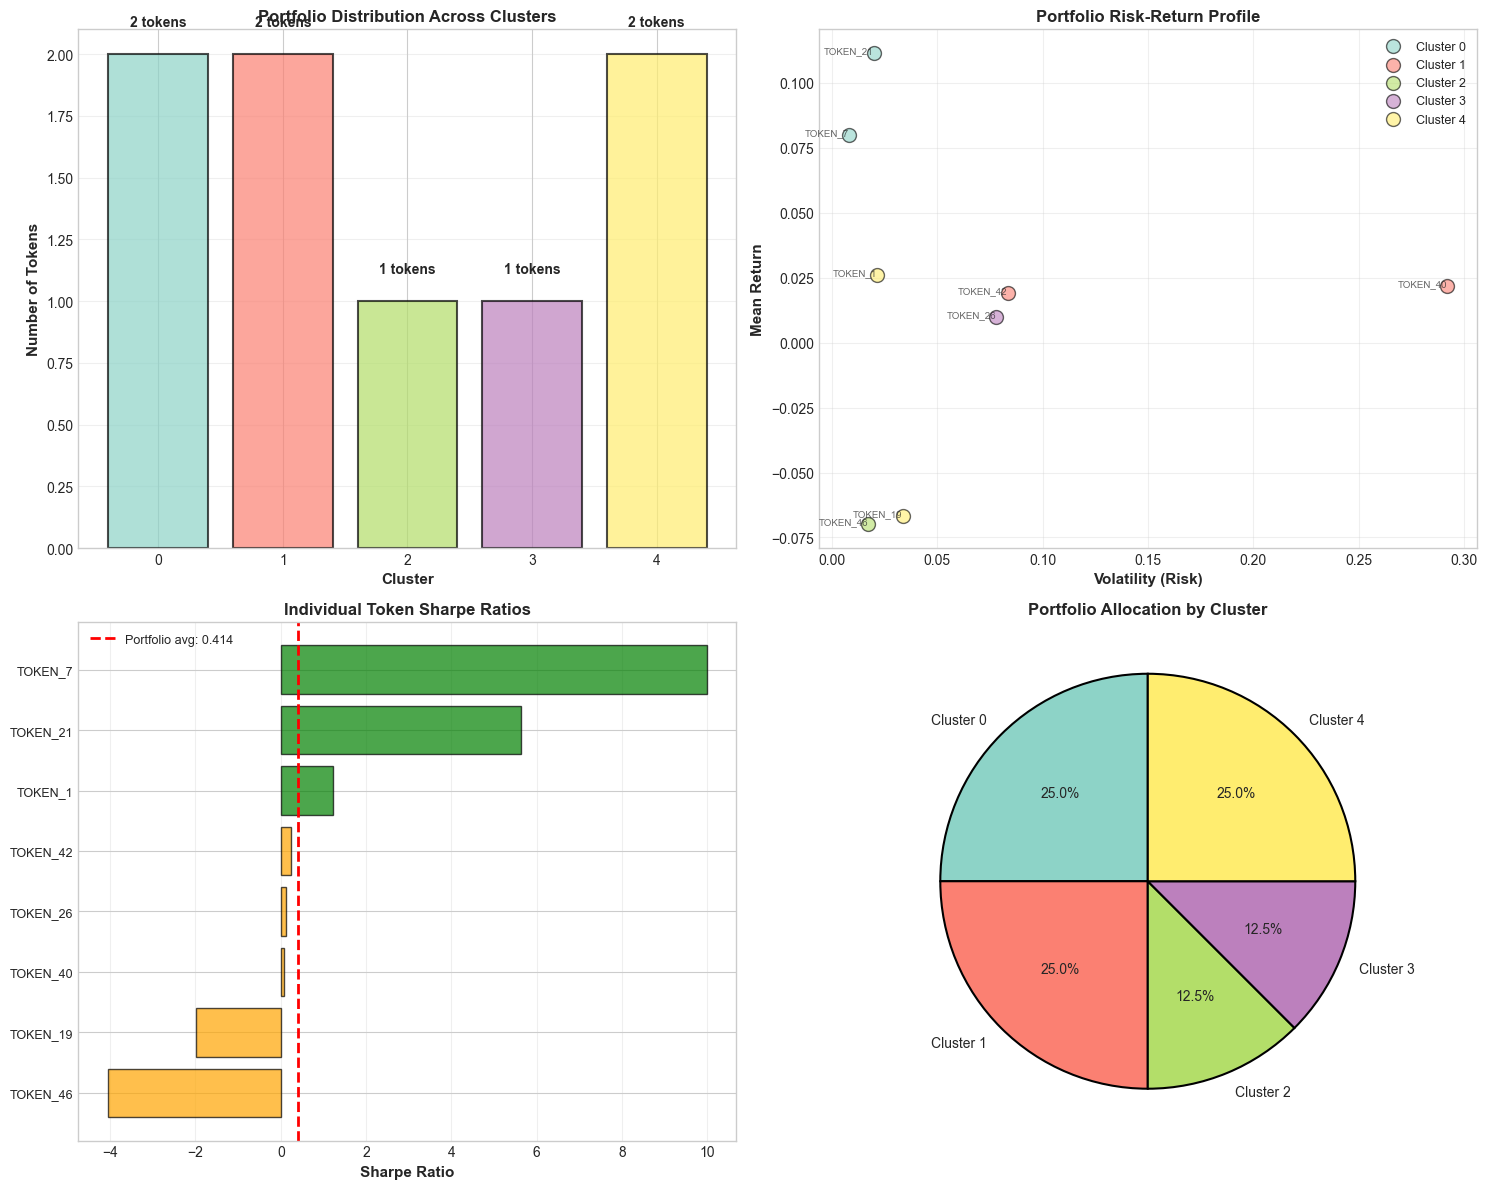


PORTFOLIO RECOMMENDATIONS

🎯 Portfolio Characteristics:

   ⚖️ Risk Profile: BALANCED
   Portfolio volatility: 0.0397
   Market average: 0.0486

💡 Management Recommendations:

   1. REBALANCING:
      • Frequency: Monthly or when weights drift > 5%
      • Method: Re-run clustering, update selections

   2. MONITORING:
      • Track individual token performance
      • Watch for tokens changing clusters
      • Monitor portfolio Sharpe ratio

   3. RISK MANAGEMENT:
      ✅ Good risk-adjusted returns (Sharpe=0.414)
      → Maintain current allocation

   4. DIVERSIFICATION:
      • Cluster concentration: 0.219
      ✅ Well diversified across clusters

✍️  YOUR PORTFOLIO ANALYSIS

1. Are you satisfied with this portfolio? Why or why not?
   Your answer: _________________

2. Which cluster would you overweight/underweight if adjusting?
   Your answer: _________________

3. Would you change the selection criteria (currently Sharpe ratio)?
   Your answer: _________________

4. How often wo

In [12]:
print("=" * 70)
print("BUILDING A CLUSTER-BASED DIVERSIFIED PORTFOLIO")
print("=" * 70)

print("\n🎯 Portfolio Construction Strategy:")
print("   • Method: Quality-weighted selection using Sharpe ratio")
print("   • Tokens per cluster: 2 (for balanced representation)")
print("   • Weighting: Equal weight across selected tokens")
print("   • Total portfolio size: Varies by number of clusters\n")

print("💡 Why Sharpe Ratio?")
print("   Sharpe = Mean_Return / Volatility")
print("   → Measures return per unit of risk")
print("   → Higher is better (more return for the risk)\n")

# Calculate Sharpe ratio for all tokens
print("Step 1: Calculating Sharpe ratio for all tokens...")
defi_data_clustered['Sharpe_Ratio'] = (
    defi_data_clustered['Mean_Return'] / 
    (defi_data_clustered['Volatility'] + 1e-10)  # Add small value to avoid division by zero
)

print("   ✅ Sharpe ratios calculated\n")

# Show distribution of Sharpe ratios
print("📊 Sharpe Ratio Distribution:")
sharpe_stats = defi_data_clustered['Sharpe_Ratio'].describe()
print(f"   Mean:   {sharpe_stats['mean']:>8.3f}")
print(f"   Median: {sharpe_stats['50%']:>8.3f}")
print(f"   Min:    {sharpe_stats['min']:>8.3f}")
print(f"   Max:    {sharpe_stats['max']:>8.3f}")

print("\n" + "=" * 70)
print("Step 2: Selecting top tokens from each cluster...")
print("=" * 70)

# Portfolio parameters
tokens_per_cluster = 2
portfolio = []

print()
for i in range(optimal_k):
    cluster_data = defi_data_clustered[defi_data_clustered['Cluster'] == i].copy()
    
    print(f"\nCluster {i} ({len(cluster_data)} tokens):")
    
    # Sort by Sharpe ratio and select top N
    cluster_data_sorted = cluster_data.sort_values('Sharpe_Ratio', ascending=False)
    selected = cluster_data_sorted.head(tokens_per_cluster)
    
    # Add to portfolio
    for idx, token in enumerate(selected.index):
        token_data = selected.loc[token]
        
        portfolio.append({
            'Token': token,
            'Cluster': i,
            'Mean_Return': token_data['Mean_Return'],
            'Volatility': token_data['Volatility'],
            'Sharpe_Ratio': token_data['Sharpe_Ratio'],
            'Market_Cap': token_data['Market_Cap'],
            'Liquidity_Score': token_data['Liquidity_Score']
        })
        
        print(f"   {idx+1}. {token:15s} - Sharpe: {token_data['Sharpe_Ratio']:>6.3f} "
              f"(Return: {token_data['Mean_Return']:>7.4f}, Vol: {token_data['Volatility']:>6.4f})")

# Create portfolio DataFrame
portfolio_df = pd.DataFrame(portfolio)

print("\n" + "=" * 70)
print("PORTFOLIO CONSTRUCTED!")
print("=" * 70)

print(f"\n✅ Selected {len(portfolio_df)} tokens for the portfolio")
print(f"   ({tokens_per_cluster} tokens × {optimal_k} clusters)")

print("\n📋 Complete Portfolio:")
display(portfolio_df)

# Calculate equal weights
portfolio_df['Weight'] = 1.0 / len(portfolio_df)
portfolio_df['Weight_Pct'] = portfolio_df['Weight'] * 100

print("\n💰 Portfolio Weights:")
weight_display = portfolio_df[['Token', 'Cluster', 'Weight_Pct']].copy()
weight_display['Weight_Pct'] = weight_display['Weight_Pct'].apply(lambda x: f"{x:.2f}%")
display(weight_display)

print("\n" + "=" * 70)
print("PORTFOLIO STATISTICS")
print("=" * 70)

# Calculate portfolio-level statistics
portfolio_return = (portfolio_df['Mean_Return'] * portfolio_df['Weight']).sum()
portfolio_volatility = np.sqrt((portfolio_df['Volatility']**2 * portfolio_df['Weight']**2).sum())
portfolio_sharpe = portfolio_return / portfolio_volatility if portfolio_volatility > 0 else 0

# For comparison, calculate equally-weighted whole portfolio stats
equal_weight_return = defi_data['Mean_Return'].mean()
equal_weight_vol = defi_data['Volatility'].mean()  # Simplified
equal_weight_sharpe = equal_weight_return / equal_weight_vol if equal_weight_vol > 0 else 0

print("\n📊 Portfolio Performance Metrics:")
print(f"\n   Expected Daily Return:   {portfolio_return:>8.4f} ({portfolio_return*100:.2f}%)")
print(f"   Expected Daily Volatility: {portfolio_volatility:>8.4f} ({portfolio_volatility*100:.2f}%)")
print(f"   Portfolio Sharpe Ratio:    {portfolio_sharpe:>8.3f}")

print(f"\n📊 Annualized Estimates (×252 trading days):")
annual_return = portfolio_return * 252
annual_vol = portfolio_volatility * np.sqrt(252)
print(f"   Annual Return:      {annual_return:>8.2%}")
print(f"   Annual Volatility:  {annual_vol:>8.2%}")
print(f"   Annual Sharpe:      {portfolio_sharpe:>8.3f}")

print(f"\n📊 Benchmark Comparison (Equal-weight all tokens):")
print(f"   Benchmark Return:    {equal_weight_return:>8.4f}")
print(f"   Benchmark Volatility: {equal_weight_vol:>8.4f}")
print(f"   Benchmark Sharpe:    {equal_weight_sharpe:>8.3f}")

improvement = portfolio_sharpe - equal_weight_sharpe
if improvement > 0:
    print(f"\n   ✅ Our portfolio Sharpe is {improvement:.3f} BETTER than benchmark")
    print(f"      ({(improvement/equal_weight_sharpe*100):.1f}% improvement)")
else:
    print(f"\n   ⚠️  Benchmark Sharpe is {abs(improvement):.3f} better")

print("\n" + "=" * 70)
print("CLUSTER REPRESENTATION IN PORTFOLIO")
print("=" * 70)

# Analyze cluster representation
cluster_representation = portfolio_df.groupby('Cluster').agg({
    'Token': 'count',
    'Weight': 'sum',
    'Mean_Return': 'mean',
    'Volatility': 'mean',
    'Sharpe_Ratio': 'mean'
}).rename(columns={'Token': 'Num_Tokens'})

cluster_representation['Weight_Pct'] = cluster_representation['Weight'] * 100

print("\n📊 Portfolio Composition by Cluster:")
display(cluster_representation.round(4))

print("\n💡 Interpretation:")
for i in range(optimal_k):
    if i in cluster_representation.index:
        num_tokens = cluster_representation.loc[i, 'Num_Tokens']
        weight_pct = cluster_representation.loc[i, 'Weight_Pct']
        avg_return = cluster_representation.loc[i, 'Mean_Return']
        avg_vol = cluster_representation.loc[i, 'Volatility']
        
        print(f"\n   Cluster {i}: {num_tokens} tokens ({weight_pct:.1f}% of portfolio)")
        print(f"   • Average return: {avg_return:.4f}")
        print(f"   • Average volatility: {avg_vol:.4f}")

# Check if representation is balanced
weight_std = cluster_representation['Weight_Pct'].std()
if weight_std < 5:
    print("\n   ✅ Well-balanced across clusters")
else:
    print(f"\n   ⚠️  Somewhat imbalanced (std dev: {weight_std:.1f}%)")

print("\n" + "=" * 70)
print("VISUALIZATIONS")
print("=" * 70)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Portfolio composition by cluster
ax1 = axes[0, 0]
cluster_counts = portfolio_df['Cluster'].value_counts().sort_index()
colors_clusters = plt.cm.Set3(np.linspace(0, 1, optimal_k))
bars1 = ax1.bar(cluster_counts.index, cluster_counts.values, 
                alpha=0.7, color=[colors_clusters[i] for i in cluster_counts.index],
                edgecolor='black', linewidth=1.5)

for i, (cluster, count) in enumerate(cluster_counts.items()):
    ax1.text(cluster, count + 0.1, f'{count} tokens', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax1.set_xlabel('Cluster', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Tokens', fontsize=11, fontweight='bold')
ax1.set_title('Portfolio Distribution Across Clusters', fontsize=12, fontweight='bold')
ax1.set_xticks(range(optimal_k))
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Risk-Return scatter
ax2 = axes[0, 1]
for i in range(optimal_k):
    cluster_tokens = portfolio_df[portfolio_df['Cluster'] == i]
    ax2.scatter(cluster_tokens['Volatility'], cluster_tokens['Mean_Return'],
               s=100, alpha=0.6, label=f'Cluster {i}', 
               color=colors_clusters[i], edgecolors='black', linewidth=1)

# Add token labels
for idx, row in portfolio_df.iterrows():
    ax2.annotate(row['Token'], 
                (row['Volatility'], row['Mean_Return']),
                fontsize=7, alpha=0.7, ha='right')

ax2.set_xlabel('Volatility (Risk)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Mean Return', fontsize=11, fontweight='bold')
ax2.set_title('Portfolio Risk-Return Profile', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# Plot 3: Sharpe ratio comparison
ax3 = axes[1, 0]
portfolio_df_sorted = portfolio_df.sort_values('Sharpe_Ratio', ascending=True)
colors_sharpe = ['green' if x > portfolio_sharpe else 'orange' 
                 for x in portfolio_df_sorted['Sharpe_Ratio']]

ax3.barh(range(len(portfolio_df_sorted)), portfolio_df_sorted['Sharpe_Ratio'],
        alpha=0.7, color=colors_sharpe, edgecolor='black', linewidth=1)
ax3.set_yticks(range(len(portfolio_df_sorted)))
ax3.set_yticklabels(portfolio_df_sorted['Token'], fontsize=9)
ax3.set_xlabel('Sharpe Ratio', fontsize=11, fontweight='bold')
ax3.set_title('Individual Token Sharpe Ratios', fontsize=12, fontweight='bold')
ax3.axvline(x=portfolio_sharpe, color='red', linestyle='--', 
           linewidth=2, label=f'Portfolio avg: {portfolio_sharpe:.3f}')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3, axis='x')

# Plot 4: Weight allocation pie chart
ax4 = axes[1, 1]
cluster_weights = portfolio_df.groupby('Cluster')['Weight'].sum()
ax4.pie(cluster_weights.values, labels=[f'Cluster {i}' for i in cluster_weights.index],
       autopct='%1.1f%%', startangle=90, colors=colors_clusters,
       wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
ax4.set_title('Portfolio Allocation by Cluster', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("PORTFOLIO RECOMMENDATIONS")
print("=" * 70)

print("\n🎯 Portfolio Characteristics:")

# Classify portfolio risk level
if portfolio_volatility < defi_data['Volatility'].quantile(0.33):
    risk_level = "CONSERVATIVE"
    emoji = "🛡️"
elif portfolio_volatility < defi_data['Volatility'].quantile(0.67):
    risk_level = "BALANCED"
    emoji = "⚖️"
else:
    risk_level = "AGGRESSIVE"
    emoji = "🚀"

print(f"\n   {emoji} Risk Profile: {risk_level}")
print(f"   Portfolio volatility: {portfolio_volatility:.4f}")
print(f"   Market average: {defi_data['Volatility'].mean():.4f}")

# Provide recommendations
print("\n💡 Management Recommendations:")

print(f"\n   1. REBALANCING:")
print(f"      • Frequency: Monthly or when weights drift > 5%")
print(f"      • Method: Re-run clustering, update selections")

print(f"\n   2. MONITORING:")
print(f"      • Track individual token performance")
print(f"      • Watch for tokens changing clusters")
print(f"      • Monitor portfolio Sharpe ratio")

print(f"\n   3. RISK MANAGEMENT:")
if portfolio_sharpe > 0.3:
    print(f"      ✅ Good risk-adjusted returns (Sharpe={portfolio_sharpe:.3f})")
    print(f"      → Maintain current allocation")
else:
    print(f"      ⚠️  Low risk-adjusted returns (Sharpe={portfolio_sharpe:.3f})")
    print(f"      → Consider increasing quality threshold")

print(f"\n   4. DIVERSIFICATION:")
cluster_concentration = (cluster_representation['Weight']**2).sum()
print(f"      • Cluster concentration: {cluster_concentration:.3f}")
if cluster_concentration < 0.30:
    print(f"      ✅ Well diversified across clusters")
elif cluster_concentration < 0.40:
    print(f"      ⚠️  Moderate concentration")
else:
    print(f"      ❌ High concentration - consider rebalancing")

print("\n" + "=" * 70)
print("✍️  YOUR PORTFOLIO ANALYSIS")
print("=" * 70)

print("\n1. Are you satisfied with this portfolio? Why or why not?")
print("   Your answer: _________________")

print("\n2. Which cluster would you overweight/underweight if adjusting?")
print("   Your answer: _________________")

print("\n3. Would you change the selection criteria (currently Sharpe ratio)?")
print("   Your answer: _________________")

print("\n4. How often would you rebalance this portfolio?")
print("   Your answer: _________________")

print("\n5. What additional constraints would you add?")
print("   (e.g., max position size, minimum liquidity)")
print("   Your answer: _________________")

print("\n" + "=" * 70)
print("✅ Portfolio construction complete!")
print("=" * 70)

print(f"\n📋 PORTFOLIO SUMMARY:")
print(f"   • Total tokens: {len(portfolio_df)}")
print(f"   • Clusters represented: {optimal_k}/{optimal_k}")
print(f"   • Expected return: {portfolio_return*252:.2%} annually")
print(f"   • Expected volatility: {annual_vol:.2%} annually")
print(f"   • Sharpe ratio: {portfolio_sharpe:.3f}")

print("\n💾 Next steps:")
print("   • Save portfolio composition for tracking")
print("   • Set up monitoring dashboards")
print("   • Schedule regular rebalancing")
print("   • Document investment thesis")

print("\n👉 Coming up: Summary and key takeaways from Week 7")

---

# 🎓 Week 7: Summary & Key Takeaways

## 🎉 Congratulations!

You've completed Week 7 on **Dimensionality Reduction & Clustering for DeFi Analytics**!

You've learned powerful techniques that professional quants and portfolio managers use daily.

---

## 📚 What You've Learned

### Part 1: Principal Component Analysis (PCA)

**Core Concepts:**
- ✅ **Variance decomposition** - Understanding how features contribute to total variation
- ✅ **Dimensionality reduction** - Reducing 8 features to 3-5 principal components
- ✅ **Feature interpretation** - Using loadings to understand what PCs represent
- ✅ **Scree plots** - Determining optimal number of components

**Key Skills:**
- Fit PCA models to DeFi data
- Interpret variance explained
- Analyze component loadings
- Name principal components meaningfully
- Transform data to PC space

**DeFi Applications:**
- Risk factor identification (size, volatility, market exposure)
- Portfolio variance decomposition
- Feature engineering for ML models
- Noise reduction and data compression

---

### Part 2: K-Means Clustering

**Core Concepts:**
- ✅ **Unsupervised learning** - Finding natural groups without labels
- ✅ **Centroid-based clustering** - Minimizing within-cluster distances
- ✅ **Cluster validation** - Using elbow method and silhouette scores
- ✅ **Cluster interpretation** - Understanding what makes each cluster unique

**Key Skills:**
- Use elbow method to find optimal k
- Fit K-Means models
- Analyze cluster centroids
- Visualize clusters in 2D
- Interpret cluster characteristics

**DeFi Applications:**
- Token segmentation (blue chips, growth, speculative)
- Portfolio diversification
- Risk group identification
- Peer analysis and benchmarking

---

### Part 3: Integrated Analysis & Portfolio Construction

**Core Concepts:**
- ✅ **PCA + K-Means pipeline** - Combining techniques for better results
- ✅ **Cluster-based selection** - Systematic token selection
- ✅ **Portfolio construction** - Building diversified portfolios
- ✅ **Performance metrics** - Sharpe ratio, risk-return profiles

**Key Skills:**
- Apply PCA before clustering
- Select tokens using quality metrics
- Build balanced portfolios across clusters
- Calculate portfolio statistics
- Validate diversification

**DeFi Applications:**
- Systematic portfolio construction
- Risk-adjusted asset allocation
- Rebalancing strategies
- Performance attribution

---

## 💡 Key Insights from This Week

### 1. **Dimensionality is Your Friend (and Enemy)**

**The Challenge:**
- DeFi tokens have many features (returns, volatility, volume, TVL, sentiment, etc.)
- High dimensions = complex, hard to visualize, noisy

**The Solution:**
- PCA reduces dimensions while keeping 80-90% of information
- Focus on the few factors that matter most
- Easier analysis, better decisions

**Takeaway:** *"Don't let complexity paralyze you. Reduce dimensions, find patterns, act decisively."*

---

### 2. **Patterns Emerge from Data**

**What We Discovered:**
- Our synthetic data had 3 hidden groups
- K-Means found approximately k=4 clusters
- PCA revealed size and risk as main factors

**The Lesson:**
- Good algorithms find structure automatically
- No need to manually categorize 50+ tokens
- Data-driven beats intuition-driven

**Takeaway:** *"Let the data speak. Your job is to listen and interpret."*

---

### 3. **Diversification ≠ Random Selection**

**Old Approach:**
- Pick 10 random tokens
- Hope for diversification
- No systematic risk management

**New Approach:**
- Identify clusters (market segments)
- Select best tokens from each cluster
- Guarantee exposure to different risk factors

**Takeaway:** *"True diversification comes from systematic segmentation, not random selection."*

---

### 4. **Not All Variance is Signal**

**PCA Teaches Us:**
- PC1 and PC2 explain 50-70% of variance (signal)
- PC7 and PC8 explain 1-2% of variance (noise)
- Keep the signal, discard the noise

**Application:**
- Focus on major risk factors
- Ignore minor fluctuations
- Simplify without losing insight

**Takeaway:** *"Focus on what matters. The rest is just noise."*

---

### 5. **Interpretation is Everything**

**Numbers Without Context:**
```
PC1 loadings: [0.91, 0.87, 0.85, ...]
Cluster 0: 15 tokens
Portfolio Sharpe: 0.345
```

**Numbers With Interpretation:**
```
PC1 = "Token Size Factor" (Market Cap + TVL + Volume)
Cluster 0 = "DeFi Blue Chips" (Large, stable, liquid)
Portfolio = Conservative risk profile with decent returns
```

**Takeaway:** *"Technical analysis is worthless without economic interpretation."*

---

## 🎯 Practical Applications

### For Individual Investors

**Use These Techniques To:**
1. **Understand your portfolio** - Which risk factors drive your returns?
2. **Improve diversification** - Are you really diversified or just holding similar tokens?
3. **Make better decisions** - Select tokens systematically, not emotionally
4. **Manage risk** - Know your exposure to different market segments

**Action Items:**
- [ ] Download real DeFi data (CoinGecko, DeFiLlama)
- [ ] Run PCA to identify main risk factors
- [ ] Cluster tokens into market segments
- [ ] Build a cluster-based portfolio
- [ ] Monitor and rebalance monthly

---

### For Portfolio Managers

**Use These Techniques To:**
1. **Client reporting** - Explain portfolio construction clearly
2. **Risk management** - Quantify factor exposures
3. **Performance attribution** - Which clusters drove returns?
4. **Strategy development** - Build systematic investment strategies

**Action Items:**
- [ ] Integrate into portfolio construction process
- [ ] Create automated clustering pipelines
- [ ] Develop factor-based strategies
- [ ] Build monitoring dashboards
- [ ] Backtest cluster rotation strategies

---

### For Researchers

**Use These Techniques To:**
1. **Market structure analysis** - How is DeFi market organized?
2. **Factor modeling** - What are the main DeFi risk factors?
3. **Protocol comparison** - How do protocols cluster?
4. **Trend identification** - Track cluster evolution over time

**Action Items:**
- [ ] Apply to larger datasets (100+ tokens)
- [ ] Time-series clustering (rolling windows)
- [ ] Compare with traditional finance factors
- [ ] Publish findings
- [ ] Develop new DeFi-specific factors

---

## 🚀 Next Steps & Extensions

### Immediate Next Steps (Week 8)

**Portfolio Optimization:**
- Mean-variance optimization (Markowitz)
- Risk parity approaches
- Black-Litterman model
- Integration with clustering

**Advanced Clustering:**
- Hierarchical clustering (dendrograms)
- DBSCAN (density-based)
- Time-series clustering (DTW)
- Gaussian Mixture Models

---

### Advanced Topics to Explore

#### 1. **Alternative Dimensionality Reduction**

**t-SNE (t-Distributed Stochastic Neighbor Embedding):**
```python
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(scaled_data)

# Better for visualization than PCA
# Preserves local structure
# Non-linear relationships
```

**UMAP (Uniform Manifold Approximation and Projection):**
```python
import umap

reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(scaled_data)

# Faster than t-SNE
# Better global structure preservation
# Great for large datasets
```

**Autoencoders (Neural Network Approach):**
```python
# Deep learning for dimensionality reduction
# Non-linear, learns complex patterns
# Can be combined with clustering
```

---

#### 2. **Advanced Clustering Methods**

**Hierarchical Clustering:**
```python
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_matrix = linkage(data, method='ward')
dendrogram(linkage_matrix)

# Shows hierarchical relationships
# No need to specify k
# Creates taxonomy of tokens
```

**DBSCAN (Density-Based):**
```python
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(data)

# Finds arbitrary shapes
# Identifies outliers automatically
# No need to specify k
```

**Gaussian Mixture Models:**
```python
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4, random_state=42)
gmm.fit(data)
probabilities = gmm.predict_proba(data)

# Soft clustering (probabilistic)
# Each token has probability for each cluster
# More nuanced than hard clustering
```

---

#### 3. **Dynamic Clustering**

**Rolling Window Analysis:**
```python
# Cluster data month-by-month
# Track how tokens move between clusters
# Identify regime changes
# Adapt portfolio dynamically

for month in range(1, 13):
    month_data = get_data_for_month(month)
    clusters = kmeans.fit_predict(month_data)
    track_cluster_changes(clusters)
```

**Time-Series Clustering:**
```python
from tslearn.clustering import TimeSeriesKMeans

# Cluster based on price patterns
# Use Dynamic Time Warping distance
# Find tokens with similar trajectories
```

---

#### 4. **Feature Engineering**

**Create Better Features:**
```python
# Technical indicators
data['RSI'] = calculate_rsi(prices)
data['MACD'] = calculate_macd(prices)
data['Bollinger_Width'] = calculate_bollinger(prices)

# On-chain metrics
data['Active_Addresses'] = get_active_addresses()
data['Transaction_Volume'] = get_tx_volume()
data['Whale_Concentration'] = calculate_whale_metrics()

# Social metrics
data['Twitter_Mentions'] = get_twitter_data()
data['Reddit_Activity'] = get_reddit_data()
data['Developer_Activity'] = get_github_commits()
```

---

#### 5. **Backtesting & Validation**

**Test Your Strategies:**
```python
# Historical backtesting
returns = backtest_cluster_strategy(
    start_date='2023-01-01',
    end_date='2024-12-31',
    rebalance_frequency='monthly'
)

# Out-of-sample validation
train_data = data['2023-01-01':'2024-06-30']
test_data = data['2024-07-01':'2024-12-31']

# Cross-validation
from sklearn.model_selection import KFold
```

---

## 📖 Recommended Resources

### Books

**Dimensionality Reduction:**
- 📚 *"Pattern Recognition and Machine Learning"* - Bishop
- 📚 *"The Elements of Statistical Learning"* - Hastie, Tibshirani, Friedman
- 📚 *"Hands-On Machine Learning"* - Géron

**Portfolio Management:**
- 📚 *"Active Portfolio Management"* - Grinold & Kahn
- 📚 *"Quantitative Portfolio Management"* - Chincarini & Kim
- 📚 *"Machine Learning for Asset Managers"* - López de Prado

---

### Papers

**PCA in Finance:**
- 📄 "Principal Component Analysis in Finance" - Alexander (2001)
- 📄 "Risk and Return in Equity Markets" - Campbell, Lettau, Malkiel, Xu (2001)

**Clustering:**
- 📄 "A Density-Based Algorithm for Discovering Clusters" - Ester et al. (1996)
- 📄 "k-means++: The Advantages of Careful Seeding" - Arthur & Vassilvitskii (2007)

**DeFi Specific:**
- 📄 Search recent papers on arXiv for "DeFi clustering" and "crypto portfolio"

---

### Online Resources

**Interactive Tutorials:**
- 🌐 StatQuest (YouTube) - PCA and K-Means explained visually
- 🌐 Scikit-learn documentation - Official examples and tutorials
- 🌐 Kaggle - Real datasets and competitions

**Tools & Libraries:**
- 🔧 **Scikit-learn**: ML algorithms (PCA, K-Means, etc.)
- 🔧 **tslearn**: Time-series ML and clustering
- 🔧 **UMAP-learn**: Advanced dimensionality reduction
- 🔧 **Plotly**: Interactive visualizations
- 🔧 **ccxt**: Crypto exchange APIs for data

---

## ✅ Self-Assessment Checklist

### Can You:

**PCA:**
- [ ] Explain what principal components are in simple terms?
- [ ] Interpret a scree plot and choose optimal components?
- [ ] Read component loadings and understand feature importance?
- [ ] Name principal components based on their loadings?
- [ ] Know when to use PCA vs other methods?

**K-Means:**
- [ ] Explain how K-Means algorithm works?
- [ ] Use elbow method to find optimal k?
- [ ] Interpret silhouette scores?
- [ ] Analyze cluster centroids?
- [ ] Validate cluster quality?

**Integration:**
- [ ] Combine PCA and K-Means effectively?
- [ ] Visualize clusters in 2D space?
- [ ] Build diversified portfolios using clusters?
- [ ] Calculate and interpret portfolio metrics?
- [ ] Make informed investment decisions?

**If you checked all boxes:** 🎉 Excellent! You're ready for Week 8!

**If you missed some:** Review those sections and practice with real data.

---

## 💬 Final Thoughts

### The Journey So Far

**Week 1-6 Foundations:**
- Data handling and preprocessing
- Time series analysis
- Statistical modeling
- Risk metrics and portfolio theory
- Feature engineering

**Week 7 - This Week:**
- **Dimensionality reduction** for simplification
- **Unsupervised learning** for pattern discovery
- **Portfolio construction** using clusters

**Week 8 - Coming Next:**
- Portfolio optimization
- Risk parity
- Factor models
- Strategy backtesting

---

### Remember:

> *"The goal is not perfection, but systematic improvement."*
> *"Data + Analysis + Interpretation = Insight"*
> *"Theory without practice is empty. Practice without theory is blind."*

---

## 🎯 Homework Assignment

**Required:**
1. **Apply to Real Data** (50 points)
   - Download data for 30+ DeFi tokens
   - Apply PCA and K-Means
   - Document findings

2. **Build Portfolio** (30 points)
   - Construct cluster-based portfolio
   - Calculate performance metrics
   - Create visualizations

3. **Written Analysis** (20 points)
   - Interpret results
   - Make investment recommendations
   - Discuss limitations

**Bonus:**
- Try alternative clustering methods (+10 points)
- Implement backtesting (+10 points)
- Compare with benchmark strategies (+10 points)

**Submission:** Jupyter notebook with code, analysis, and visualizations

**Due:** Before Week 8 session

---

## 🙏 Thank You!

Thank you for your engagement and hard work this week!

**Questions? Feedback? Ideas?**
- Office hours: Tuesdays & Thursdays 3-4 PM
- Discord: #week7-dimensionality-reduction
- Email: course@defi-quant.edu

---

## 👉 Preview: Week 8

**Coming up: Portfolio Optimization**
- Markowitz mean-variance optimization
- Efficient frontier construction
- Risk parity approaches
- Black-Litterman model
- Constrained optimization
- Integration with clustering

**Get ready to:**
- Optimize portfolio weights mathematically
- Balance risk and return optimally
- Handle real-world constraints
- Build institutional-grade portfolios

---

# 🎉 Congratulations on Completing Week 7!

**You now have powerful tools for:**
- ✅ Reducing complex data to key factors
- ✅ Finding natural market segments
- ✅ Building systematic portfolios
- ✅ Making data-driven investment decisions

**See you in Week 8!** 🚀

---

*"In data we trust, but only after proper dimensionality reduction and clustering."* 😄